# DeepFM

## 0. Imports

In [1]:
# Basic Data Analysis Tools
import numpy as np
import pandas as pd
from os.path import exists
import itertools
from ast import literal_eval

# Keras imports for deepFM, 1st & 2nd order FM: all of which can be implemented as neural networks
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

# Hyperparameter tunning
import talos

# TODO: shapley for feature importance evaluation
#import shap
#from tensorflow.compat.v1.keras.backend import get_session
#tf.compat.v1.disable_v2_behavior()

In [36]:
def transaction_preprocess(transactions, train_bounds, test_bounds, time_period = 125):
    """
    args:
        transactions: pd.DataFrame -> the transaction_history.csv provided by Siemens
        train_bounds, test_bounds: (lower: int, upper: int) -> bounds for splitting dataset into train and test based on "day" feature
        time_period: map day feature into month, years, etc. (default 125 days = 4 months)
    returns:
        transactions: pd.DataFrame -> processed dataframe with encoded categories and mapped days
        train_rnd_sample: pd.DataFrame -> all positive samples within train as well as an equal number of randomly sampled negative samples
        test_rnd_sample: pd.DataFrame -> 
    """
    transactions = transactions.copy() 
    
    # encode categorical variables
    transactions["customer"] = transactions["customer"].astype('category').cat.codes + 1
    
    # FOR TESTING PURPOSES: I dont have much RAM :)
    transactions = transactions[(transactions["customer"] < 100)]
    transactions["customer"] = transactions["customer"].astype('category').cat.codes + 1
    
    transactions["day"] = transactions["day"] // time_period # map days to weeks, months, years
    transactions["prod"] = transactions["prod"].astype('category').cat.codes 
    transactions["state"] = transactions["state"].astype('category').cat.codes + 1
    transactions["ind_code"] = transactions["ind_code"].astype('category').cat.codes + 1
    transactions["ind_seg_code"] = transactions["ind_seg_code"].astype('category').cat.codes + 1
    
    # set labels to 1 - all products present were bought
    transactions["label"] = 1
    
    # create product customer list
    transactions["prod_customer"] = list(zip(transactions["customer"], transactions["prod"]))
    # drop rows with missing values
    transaction = transactions.dropna()
    
    # create train & test set
    train = transactions[(transaction.day >= train_bounds[0] // time_period) & (transactions.day < train_bounds[1] // time_period)]
    test = transactions[(transaction.day >= test_bounds[0] // time_period) & (transactions.day < test_bounds[1] // time_period)]
    
    # get unique customer and product lists
    customers = transactions["customer"].unique()
    products = train["prod"].unique() # transactions["prod"].unique() # use products only from train to make sure
    
    # set of day-customer-bought product for negative sampling
    hit_combo = set(list(zip(transactions["day"], transactions["customer"], transactions["prod"])))
    
    # get days and customers
    test_days = test["day"].unique()
    hit_combo_2 = list(zip(test["day"], test["customer"], test["prod"]))
    
    prod_list = set(products) 
    test_customer_prod_day = set([tuple(r) for r in test[["day", "customer", "prod"]].to_numpy()]) # Set of positive test_days x customer x prod
    all_test_customer_prod_day = set([x for x in itertools.product(test_days, customers, products)]) # Set of all test_days x customer x prod
    neg_test_customer_prod_day = all_test_customer_prod_day - test_customer_prod_day # Set of negative test_days x customer x prod
    
    # Create test dataset
    final_neg_sampl = test[["customer", "domestic", "state",
                            "ind_code", "ind_seg_code"]].drop_duplicates() # customer info - customer_id unique identifier of customer
    final_neg_sampl = final_neg_sampl.merge(pd.DataFrame(neg_test_customer_prod_day, columns=["day", "customer", "prod"]), how="inner", on="customer") # cartezian product of product, customer, day and customer info
    final_neg_sampl["label"] = 0 # set all products as unbought (non-sampled)
    test["label"] = 1 # set all products present in test as positive
    final_neg_sampl = final_neg_sampl.append(test.drop(["new_orders", "prod_customer"],axis=1)) # join positive and negative
    final_neg_sampl = final_neg_sampl.drop_duplicates()

    
    # specify train sample size (c)
    SAMPLE_SIZE = int(np.ceil(1.0 * len(train))) # Set negative train size
    train_days = train["day"].unique()
    
    # Bootstrap negative sample train set (only samples from train set were used) - in case no bootstraping is desired change replace -> False
    # Removes potential outliers which have for example bought only one item or that are highly unlikely to buy an item
    train_rnd_sample = np.array([np.random.choice(train_days, size=SAMPLE_SIZE),\
                                              np.random.choice(customers, size=SAMPLE_SIZE),\
                                              np.random.choice(products, size=SAMPLE_SIZE)]).T
    
    # remove samples that were actually bought (are in hit_combo)
    not_faulty = [tuple(train_rnd_sample[row,:]) not in hit_combo for row in range(train_rnd_sample.shape[0])]
    train_rnd_sample = train_rnd_sample[not_faulty]
    
    # Drop duplicated rows
    train_rnd_sample = pd.DataFrame(train_rnd_sample,
                                   columns=["day", "customer", "prod"]).drop_duplicates()
    
    # Add customer info - uniquely defined by customer_id
    train_rnd_sample = train_rnd_sample.merge(transactions[["customer", "domestic", "state", "ind_code",
                                                            "ind_seg_code"]].drop_duplicates(),
                                              on="customer")
    train_rnd_sample["label"] = 0 # Set negative labels
    
    # Merge positive and negative train samples
    train_rnd_sample = train_rnd_sample.append(train[["day", "customer", "prod", "domestic", "state", "ind_code",
                                                            "ind_seg_code", "label"]], ignore_index=True)
    
    return transactions, train_rnd_sample.sample(frac=1).reset_index(drop=True), final_neg_sampl, products, customers


In [37]:
transactions = pd.read_csv("dataset/transaction_history.csv") # load dataset
transformations = [] # includes train, test folds for CV

for i in range(1):
    print(f"Iteration {i}", end="\r")
    transformed, train, test, products, customers = transaction_preprocess(transactions, (i*125, (i+4)*125), ((i+4)*125, (i+5)*125)) 
    print(test.drop_duplicates().label.sum())
    transformations.append((train, test))
train, test = transformations[0]

1197ation 0


In [38]:
test.label.sum()

1197

## 1. Models

### 1.1 Model parts

In [39]:
def define_input_layers(df):
    """
    Defines input layers for all ML models used in this notebook.
    
    args:
        transactions: pd.DataFrame -> the transformed transaction history, with encoded categories
    returns:
        inputs: keras.inputs -> 'day', 'customer', 'prod', 'state', 'ind_code', 'ind_seg_code', 'domestic'
    """
    day_input = Input((1,), name = 'day')
    num_inputs = [day_input] # continuous numeric inputs
    cat_input = [Input((1,), name= col) for col in ['customer', 'prod', 'state', 'ind_code',
       'ind_seg_code', 'domestic']] # discrete categorical inputs
    cat_sl_inputs = [cat_input] 

    inputs = num_inputs + cat_sl_inputs # join inputs
    
    return inputs

inputs = define_input_layers(transformed)

In [40]:
def Tensor_Mean_Pooling(name = 'mean_pooling', keepdims = False):
    return Lambda(lambda x: K.mean(x, axis = 1, keepdims=keepdims), name = name)

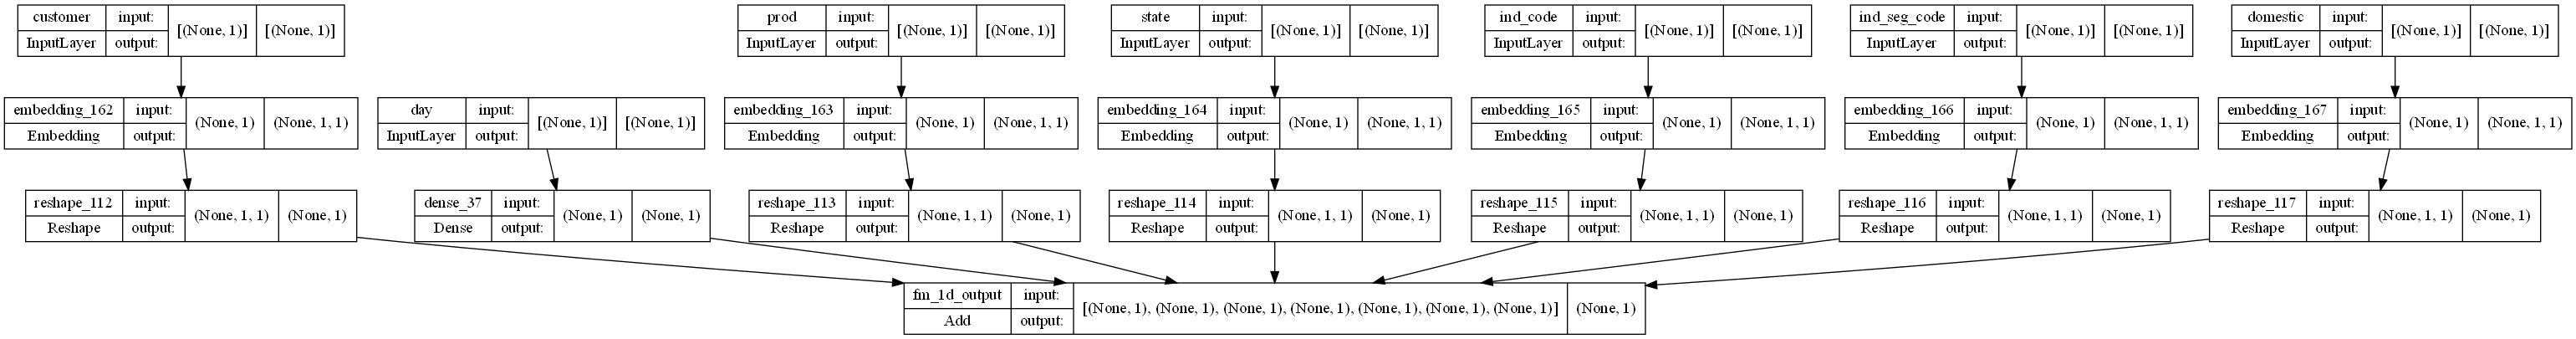

In [41]:
def fm_1d(inputs):
    """
    1st order FM output = sum a_i * f_i, linear combination of features
    
    args:
        transactions: pd.DataFrame -> the transformed transaction history, with encoded categories
    returns:
        inputs: keras.inputs -> 'day', 'customer', 'prod', 'state', 'ind_code', 'ind_seg_code', 'domestic'
    """
    num_inputs, cat_inputs = inputs 
    
    # all tensors are reshape to (None, 1)
    num_dense_1d  = [Dense(1)(num_inputs)]
    
    cat_sl_embed_1d = [Embedding(transformed[inpt.name].nunique() + 1, 1)(inpt) for inpt in cat_inputs]
    cat_sl_embed_1d = [Reshape((1,))(i) for i in cat_sl_embed_1d]
    
    # add all tensors
    y_fm_1d = Add(name = 'fm_1d_output')(num_dense_1d + cat_sl_embed_1d)
    return y_fm_1d

y_1d = fm_1d(inputs)
fm_model_1d = Model(inputs, y_1d)
plot_model(fm_model_1d, show_shapes=True, show_layer_names=True)

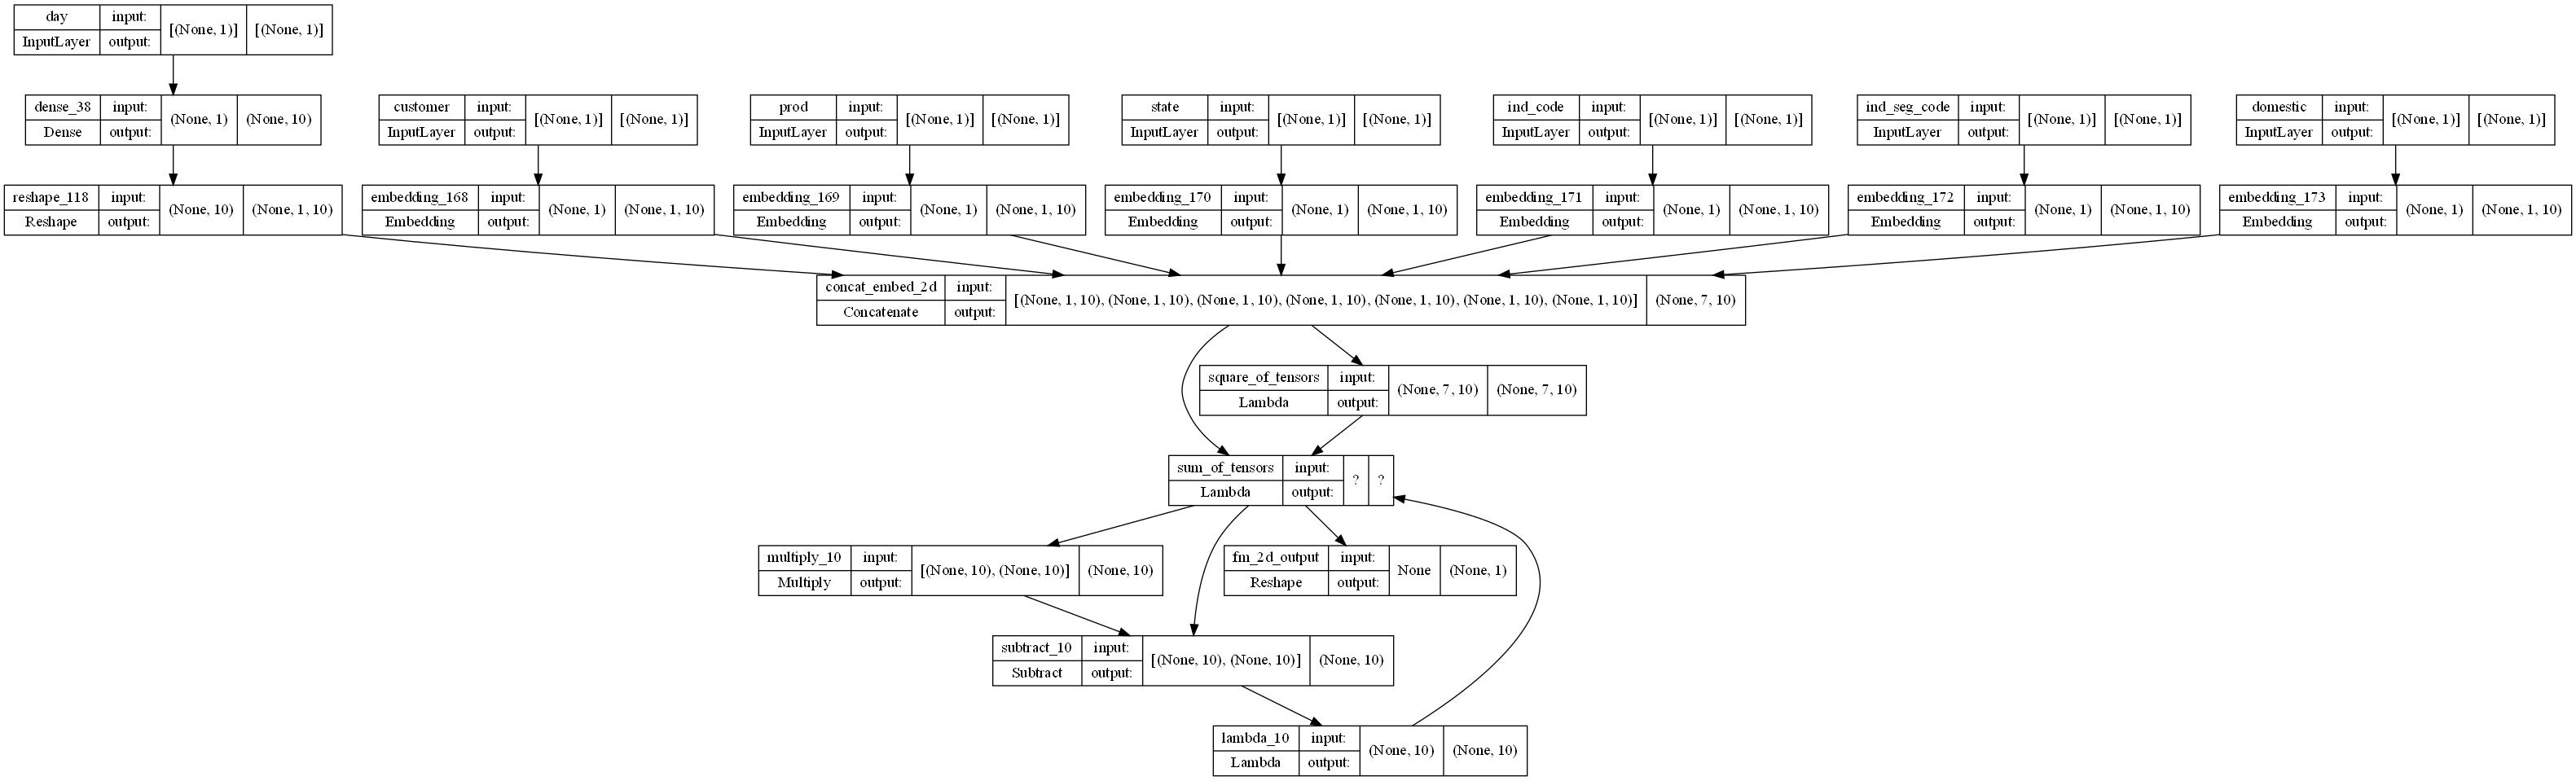

In [42]:
def fm_2d(inputs, k):
    num_inputs, cat_inputs = inputs
    
    num_dense_2d = [Dense(k)(num_inputs)]
    num_dense_2d = [Reshape((1,k))(i) for i in num_dense_2d]
    
    cat_sl_embed_2d = [Embedding(transformed[inpt.name].nunique() + 1, k)(inpt) for inpt in cat_inputs]
    
    embed_2d = Concatenate(axis=1, name = 'concat_embed_2d')(num_dense_2d + cat_sl_embed_2d)
    
    tensor_sum = Lambda(lambda x: K.sum(x, axis = 1), name = 'sum_of_tensors')
    tensor_square = Lambda(lambda x: K.square(x), name = 'square_of_tensors')

    sum_of_embed = tensor_sum(embed_2d)
    square_of_embed = tensor_square(embed_2d)
    
    square_of_sum = Multiply()([sum_of_embed, sum_of_embed])
    sum_of_square = tensor_sum(square_of_embed)
    
    sub = Subtract()([square_of_sum, sum_of_square])
    sub = Lambda(lambda x: x*0.5)(sub)
    y_fm_2d = Reshape((1,), name = 'fm_2d_output')(tensor_sum(sub))
    
    return y_fm_2d, embed_2d
    
y_2d, embed_2d = fm_2d(inputs, 10)
fm_model_2d = Model(inputs, y_2d)
plot_model(fm_model_2d, show_shapes=True, show_layer_names=True)

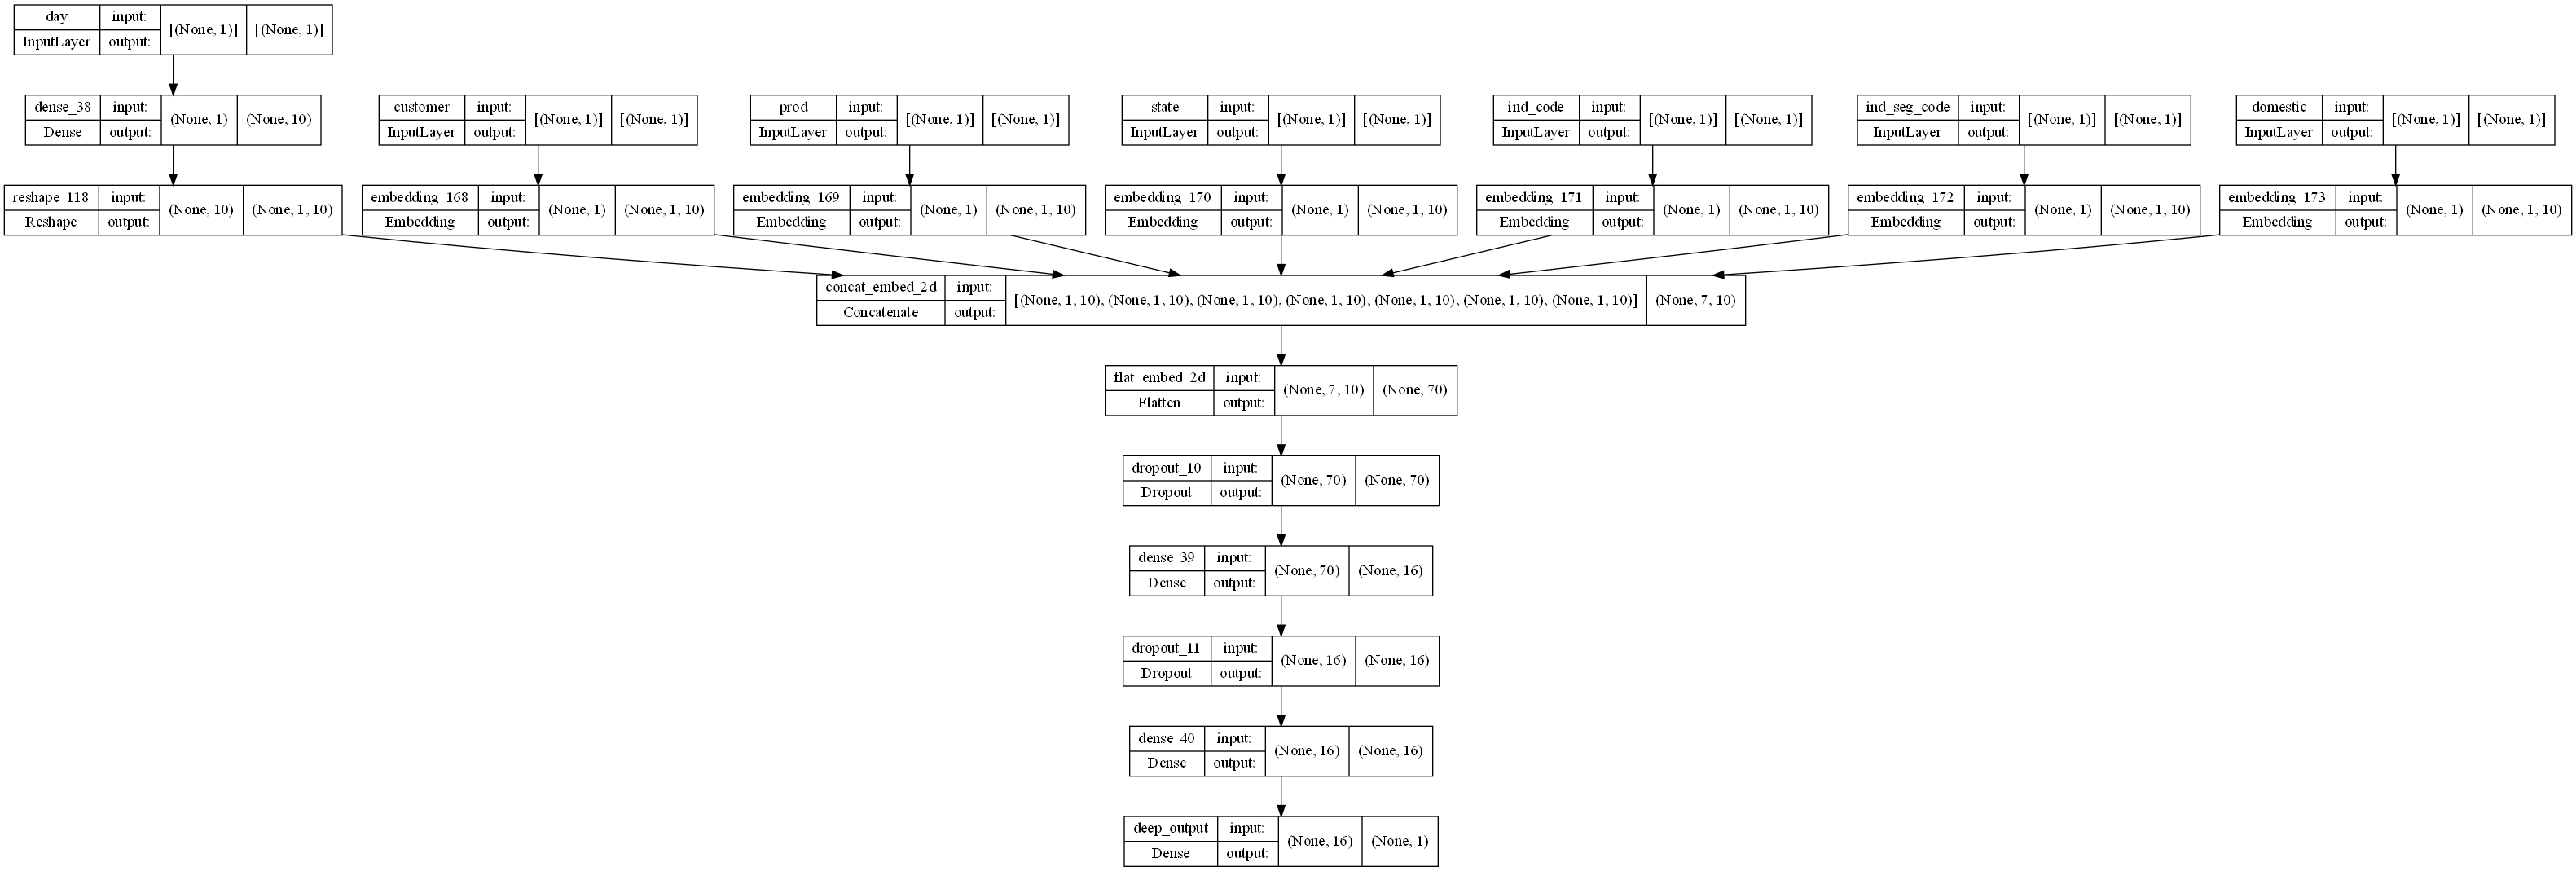

In [43]:
def dnn_part(embed_2d, dnn_dim, dnn_dr, k_reg=(1e-4, 1e-4), a_reg=(1e-4, 1e-4), act_fun="relu"):
    # flat embed layers from 3D to 2D tensors
    y_dnn = Flatten(name = 'flat_embed_2d')(embed_2d)
    for h in dnn_dim:
        y_dnn = Dropout(dnn_dr)(y_dnn)
        y_dnn = Dense(h, activation=act_fun,
                      kernel_regularizer=regularizers.L1L2(l1=k_reg[0], l2=k_reg[1]),
                      activity_regularizer=regularizers.L1L2(l1=a_reg[1], l2=a_reg[1]))(y_dnn)
    y_dnn = Dense(1, activation=act_fun, name = 'deep_output')(y_dnn)
    
    return y_dnn

y_dnn = dnn_part(embed_2d, [16, 16], 0.5)
fm_model_dnn = Model(inputs, y_dnn)
plot_model(fm_model_dnn, show_shapes=True, show_layer_names=True)

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'deep_output')>]


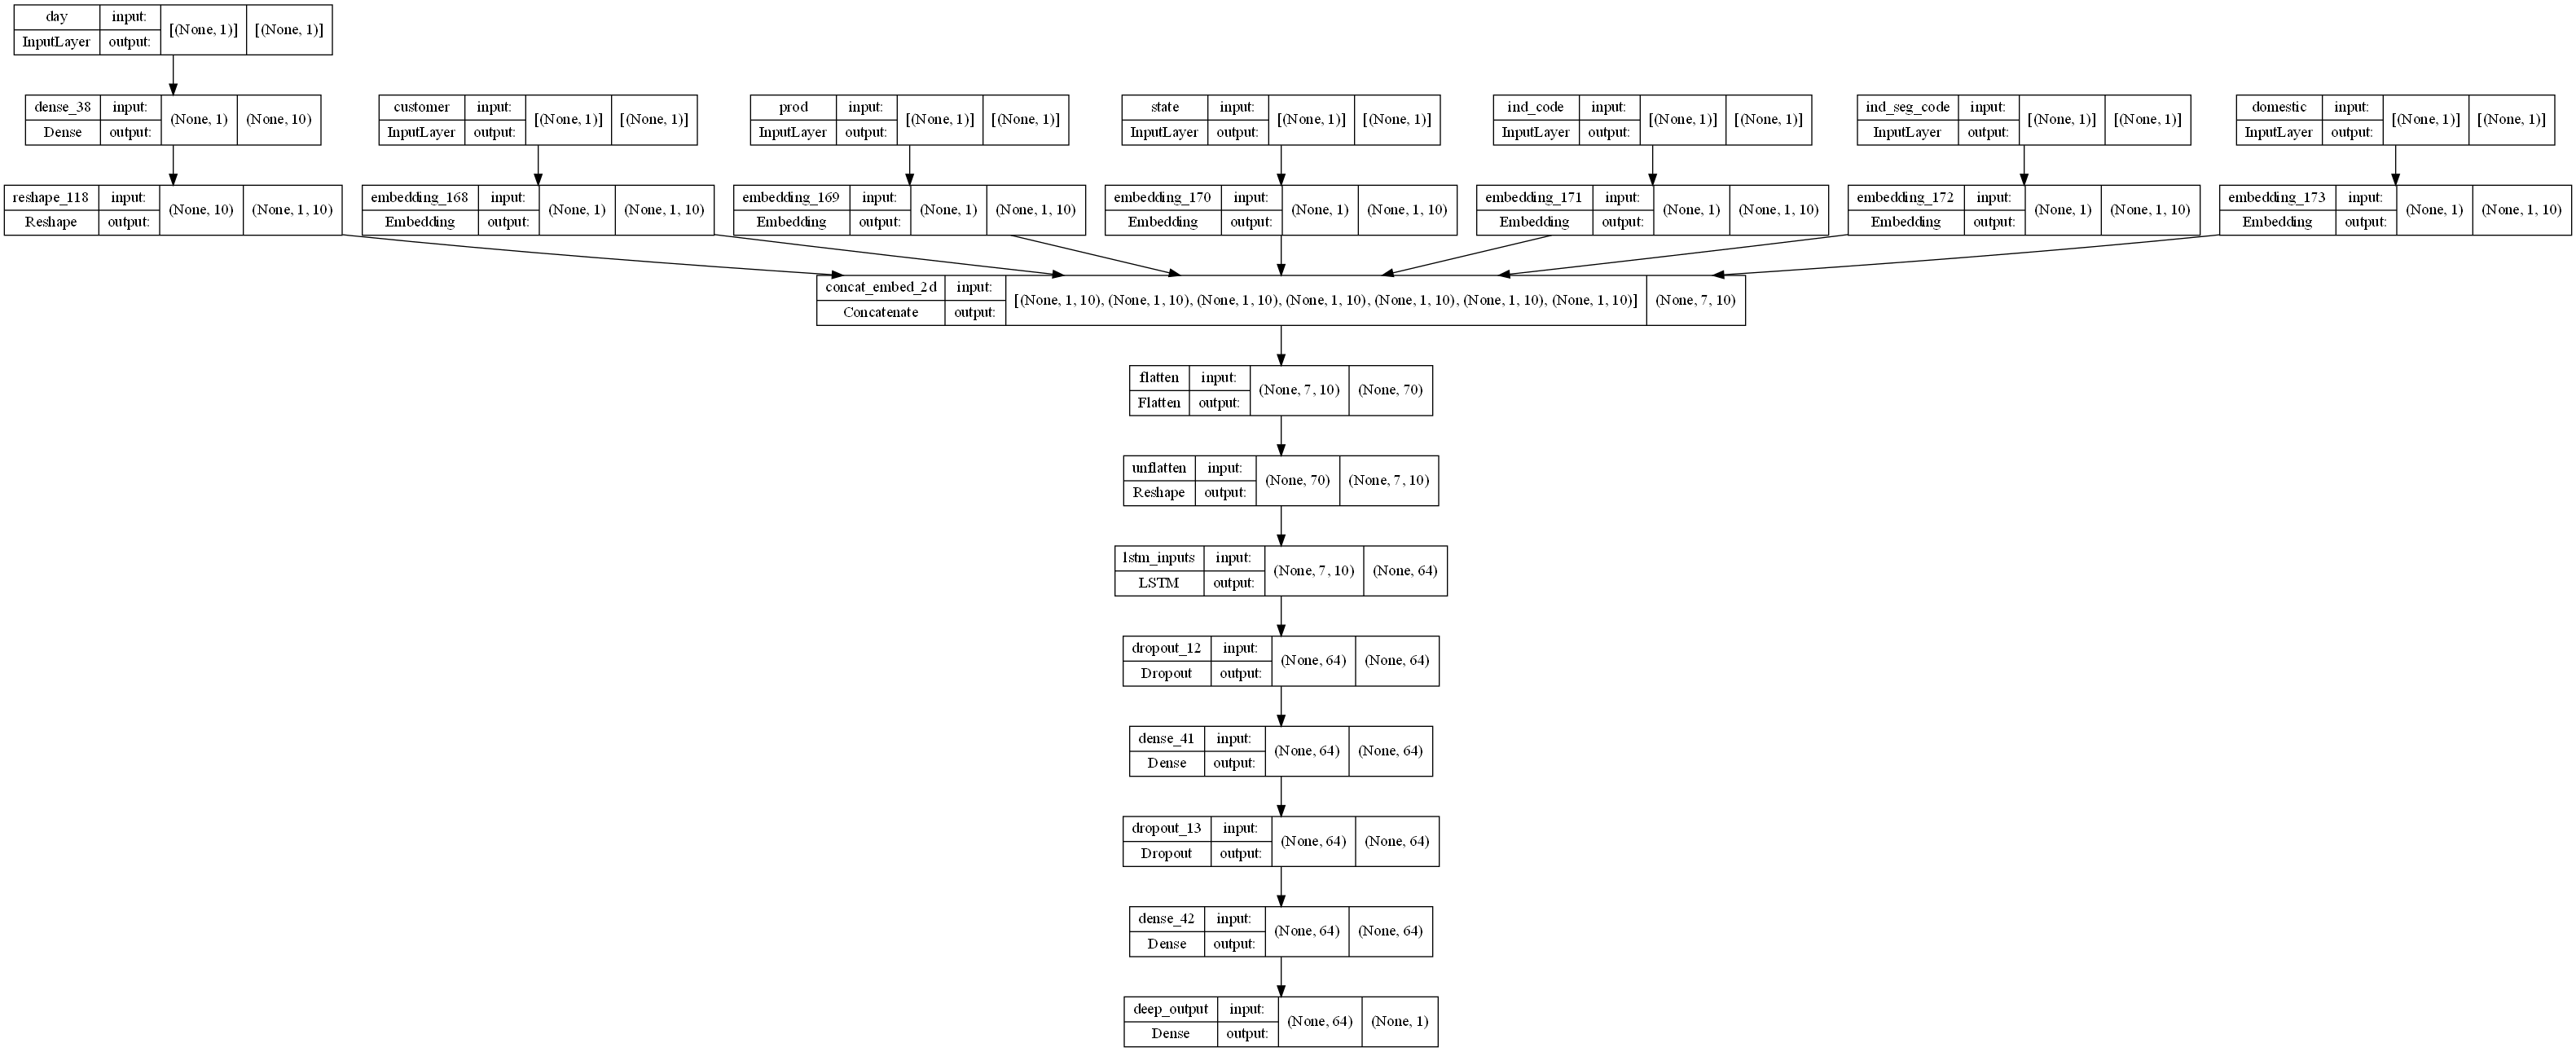

In [44]:
def lstm_part(embed_2d, lstm_dim, dnn_dim, dnn_dr, k_reg=(1e-4, 1e-4), a_reg=(1e-4, 1e-4), act_fun="relu", lstm_fun="tanh"):
    num_inputs, cat_inputs = inputs
    
    # flat embed layers from 3D to 2D tensors
    # flatten and unflatten (needed for concetanation)
    y_dnn = Flatten(name = 'flatten')(embed_2d)
    y_dnn = Reshape(embed_2d.shape[1:], name = "unflatten")(y_dnn)

    y_dnn = LSTM(lstm_dim[0], activation=lstm_fun, return_sequences=False, name="lstm_inputs",
                      kernel_regularizer=regularizers.L1L2(l1=k_reg[0], l2=k_reg[1]),
                      activity_regularizer=regularizers.L1L2(l1=a_reg[1], l2=a_reg[1]))(y_dnn) # Flatten(name = 'flat_embed_2d')(embed_2d)
    
    # print("Got to here!")
    # for h in lstm_dim[1:-1]:
    #    print("Got to here!")
    #    y_dnn = LSTM(h, return_sequences=True, activation='tanh',
    #                  kernel_regularizer=regularizers.L1(l1),
    #                  activity_regularizer=regularizers.L2(l2))(y_dnn)
    #    y_dnn = Dropout(dnn_dr)(y_dnn)
    
    #if len(lstm_dim) > 1:
    #    y_dnn = LSTM(lstm_dim[-1], return_sequences=False, activation='tanh', name="lstm_outputs",
    #                  kernel_regularizer=regularizers.L1(l1),
    #                  activity_regularizer=regularizers.L2(l2))(y_dnn)
    #    y_dnn = Dropout(dnn_dr)(y_dnn)
    
    for h in dnn_dim:
        y_dnn = Dropout(dnn_dr)(y_dnn)
        y_dnn = Dense(h, activation=act_fun,
                      kernel_regularizer=regularizers.L1L2(l1=k_reg[0], l2=k_reg[1]),
                      activity_regularizer=regularizers.L1L2(l1=a_reg[1], l2=a_reg[1]))(y_dnn)
    y_dnn = Dense(1, activation=act_fun, name = 'deep_output')(y_dnn)
    
    return y_dnn

y_dnn = lstm_part(embed_2d, [64], [64, 64], 0.5)
fm_model_dnn = Model(inputs, y_dnn)
print(fm_model_dnn.outputs)
plot_model(fm_model_dnn, show_shapes=True, show_layer_names=True)

### 1.2 Models

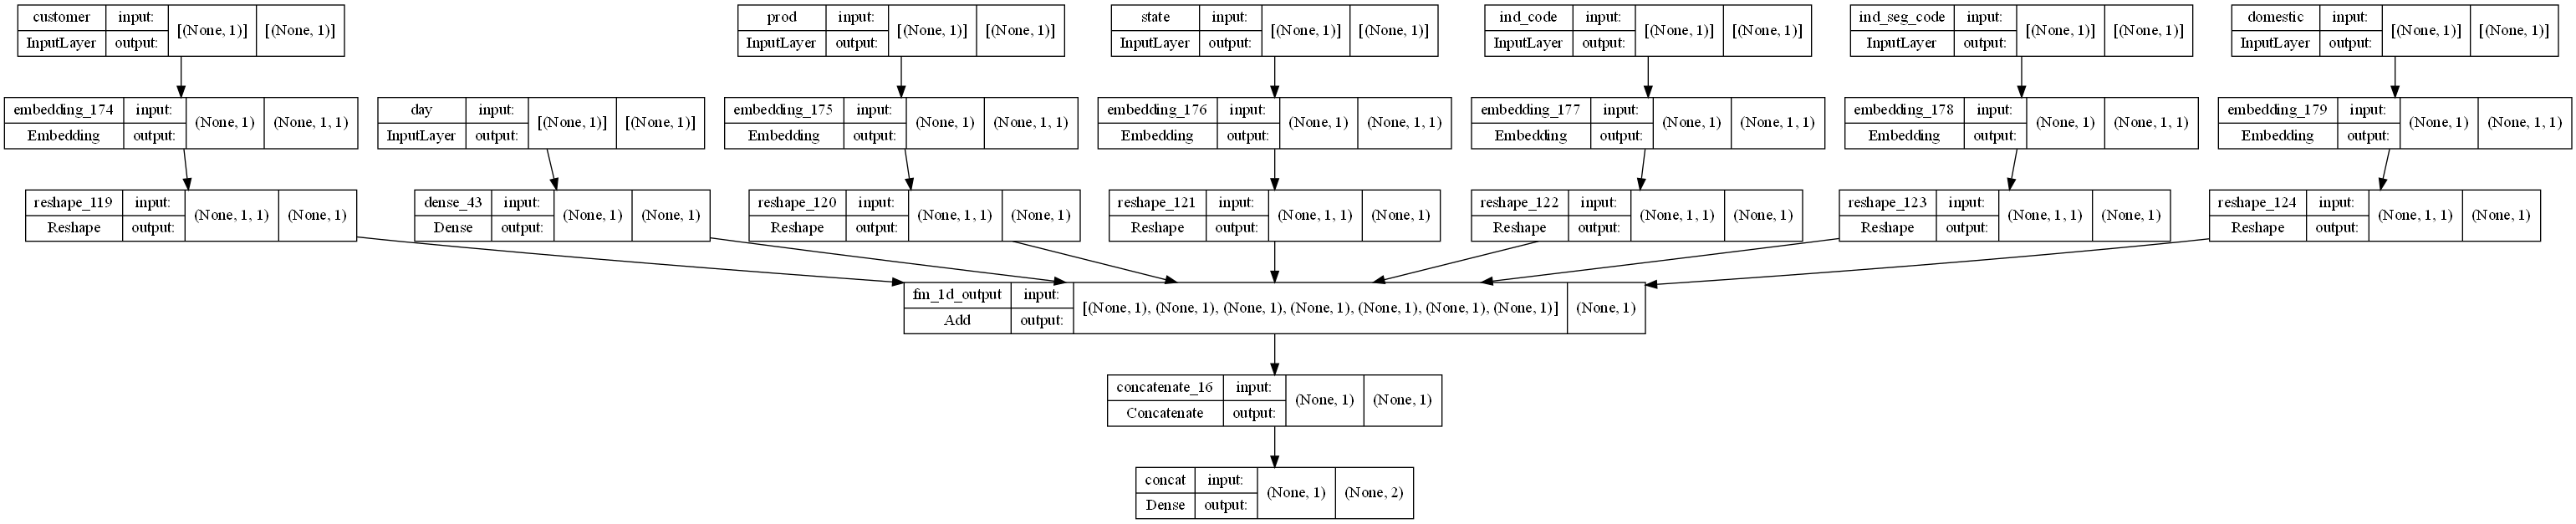

In [45]:
def mf_model():
    inputs = define_input_layers(transformed)
    y_fm_1d = fm_1d(inputs)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d])
    y = Dense(2, name = "concat")(y)
    # y = Softmax(name = 'deepfm_output')(y)
    mf_model = Model(inputs, y)
    return mf_model

MF = mf_model()
plot_model(MF, show_shapes=True, show_layer_names=True)

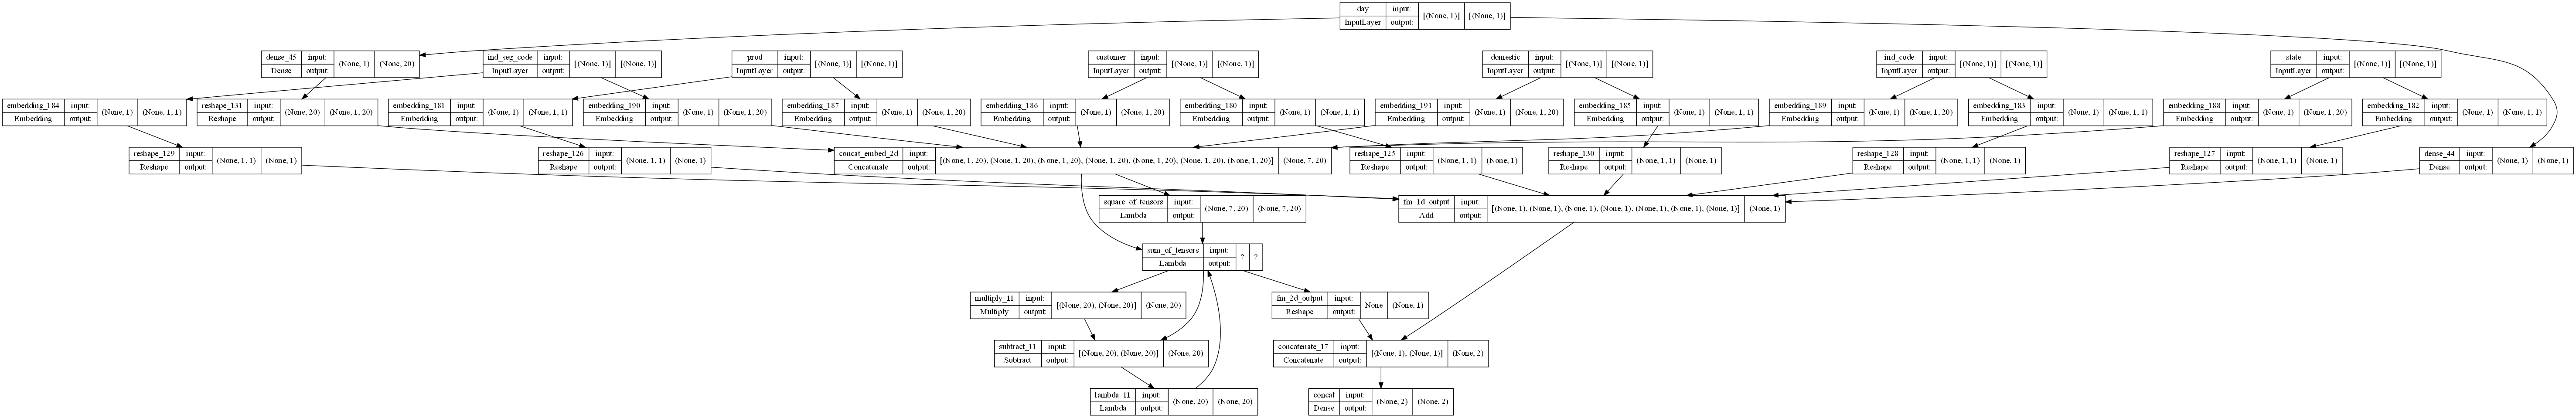

In [46]:
FM_params = {
    'k':20
}

def fm_model(k):
    inputs = define_input_layers(transformed)
    
    y_fm_1d = fm_1d(inputs)
    y_fm_2d, embed_2d = fm_2d(inputs, k)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d])
    y = Dense(2, name = "concat")(y)
    # y = Softmax(name = 'fm_output')(y)
    FM_model = Model(inputs, y)
    
    return FM_model, embed_2d
FM, _ = fm_model(**FM_params)
plot_model(FM, show_shapes=True, show_layer_names=True)

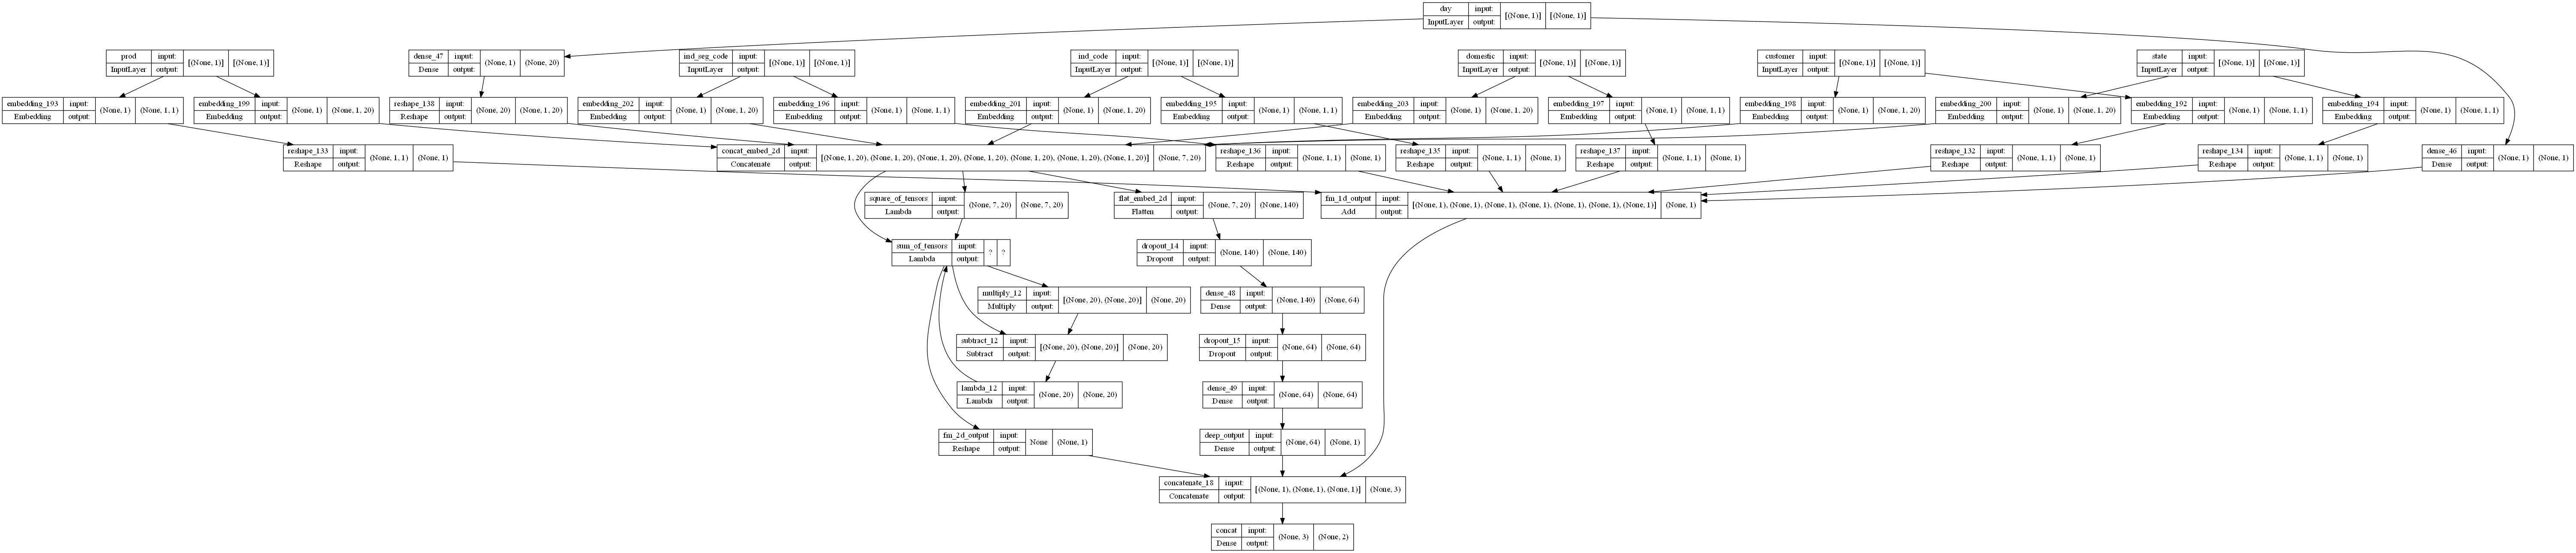

In [47]:
deepFM_params = {
    'k':20,
    'dnn_dim':[64, 64],
    'dnn_dr': 0.2
}

def deep_fm_model(k, dnn_dim, dnn_dr, k_reg=(1e-4, 1e-4), a_reg=(1e-4, 1e-4), act_fun="relu"):
    
    inputs = define_input_layers(transformed)
    
    y_fm_1d = fm_1d(inputs)
    y_fm_2d, embed_2d = fm_2d(inputs, k)
    y_dnn = dnn_part(embed_2d, dnn_dim, dnn_dr, k_reg, a_reg, act_fun)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d, y_dnn])
    y = Dense(2, name = "concat")(y)
    # y = Softmax(name = 'deepfm_output')(y)
    deep_fm_model = Model(inputs, y)
    
    return deep_fm_model
deepFM = deep_fm_model(**deepFM_params)
plot_model(deepFM, show_shapes=True, show_layer_names=True)

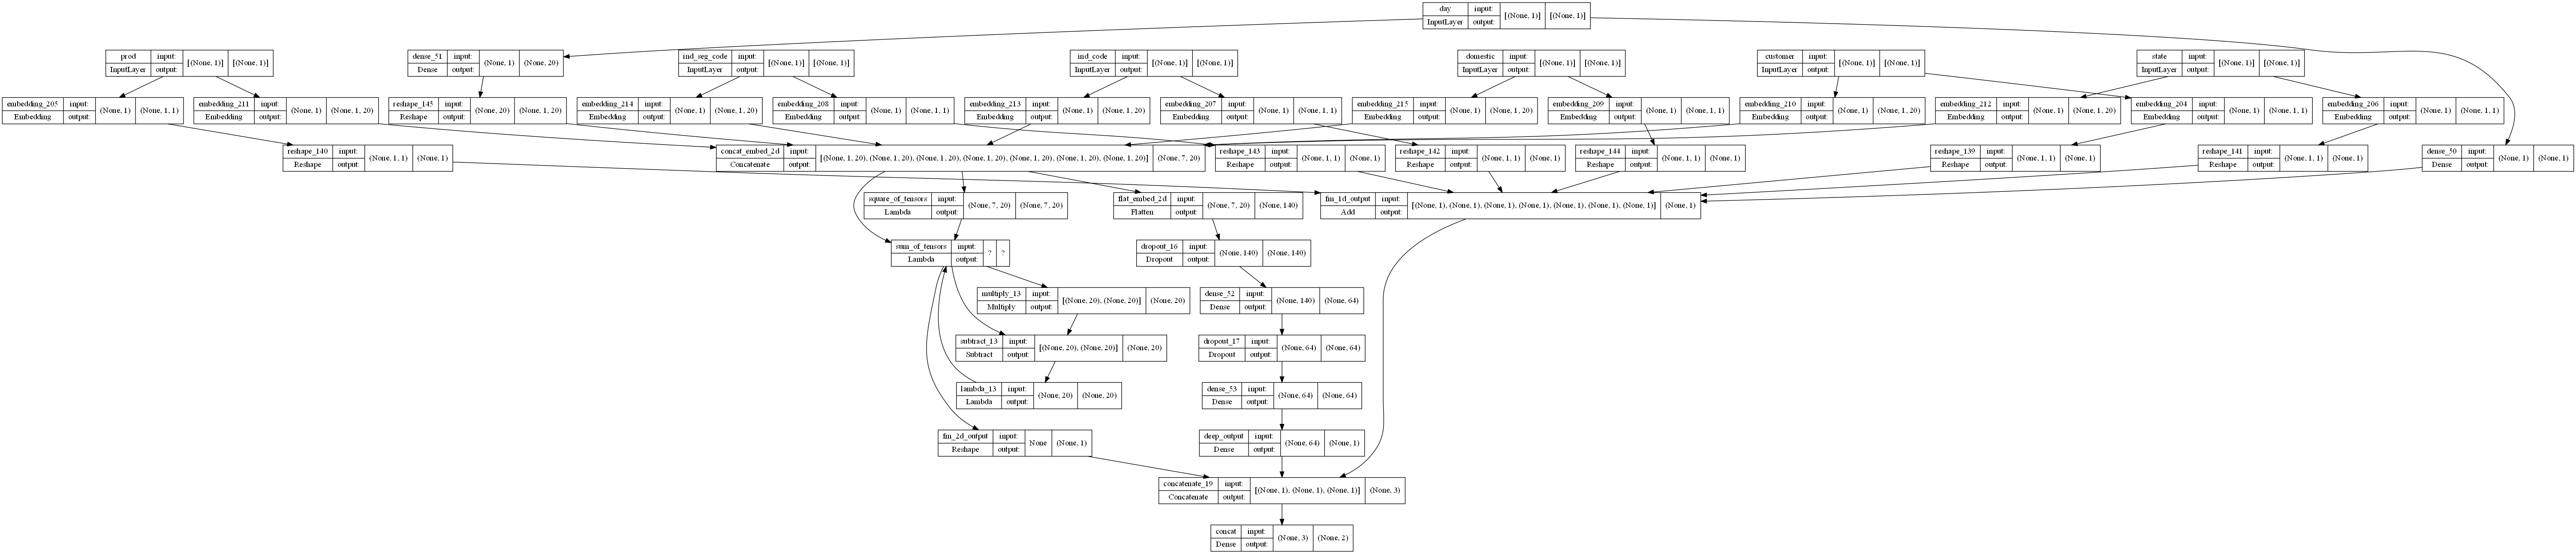

In [48]:
def lstm_fm_model(k, dnn_dim, dnn_dr, k_reg=(1e-4, 1e-4), a_reg=(1e-4, 1e-4), act_fun="relu", lstm_fun="tanh"):
    
    inputs = define_input_layers(transformed)
    
    y_fm_1d = fm_1d(inputs)
    y_fm_2d, embed_2d = fm_2d(inputs, k)
    y_dnn = lstm_part(embed_2d, dnn_dim, dnn_dr, k_reg, a_reg, act_fun, lstm_fun)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d, y_dnn])
    y = Dense(2, name = "concat")(y)
    # y = Softmax(name = 'deepfm_output')(y)
    deep_fm_model = Model(inputs, y)
    
    return deep_fm_model
deepFM = deep_fm_model(**deepFM_params)
plot_model(deepFM, show_shapes=True, show_layer_names=True)

## 2. Training

In [49]:
def df2xy(df, model):
    x = [df[inp.name].values for inp in model.inputs]
    y = df.label.values
    return x,np.asarray(y).astype('float32')

In [50]:
mf_model_arr = []

for i, transaction_tuple in zip(range(len(transformations)), transformations):
    train, test = transaction_tuple
    fm_model_1d = mf_model()
    train_x, train_y = df2xy(train, fm_model_1d)
    train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()
    
    fm_model_1d.compile(loss = 'mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    model_ckp = ModelCheckpoint(filepath=f'./models/1d_{i}_tunning.h5', 
                                        monitor='val_loss',
                                        save_weights_only=True, 
                                        save_best_only=True)
    callbacks = [early_stop, model_ckp]
    
    if not exists(f'./models/1d_{i}_tunning.h5'):
        # Train on entire train set (using optimal hyperparameters)   
        train_history = fm_model_1d.fit(train_x, train_y, 
                                              epochs=100, batch_size=1024, 
                                              validation_split=0.1, 
                                              callbacks = callbacks)
    mf_model_arr.append(fm_model_1d)
fm_model_1d.load_weights(f"./models/1d_0_tunning.h5")

Epoch 1/100
20/20 [==============================] - 1s 12ms/step - loss: 0.3874 - val_loss: 0.3580
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3349 - val_loss: 0.3137
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2987 - val_loss: 0.2865
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2786 - val_loss: 0.2733
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2699 - val_loss: 0.2681
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2664 - val_loss: 0.2657
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2645 - val_loss: 0.2640
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2629 - val_loss: 0.2626
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2615 - val_loss: 0.2613
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2602 - val_loss: 0.2601
Epoch 11

In [53]:
fm_model_arr = []

for i, transaction_tuple in zip(range(len(transformations)), transformations):
    train, test = transaction_tuple
    fm_model_2d, _ = fm_model(**FM_params)
    train_x, train_y = df2xy(train, fm_model_2d)
    train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()
    fm_model_2d.compile(loss = 'mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=15)
    model_ckp = ModelCheckpoint(filepath=f'./models/2d_{i}_tunning.h5', 
                                    monitor='val_loss',
                                    save_weights_only=True, 
                                    save_best_only=True)
    callbacks = [early_stop, model_ckp]
    if not exists(f'./models/2d_{i}_tunning.h5'):
        train_history = fm_model_2d.fit(train_x, train_y,
                                              epochs=100, batch_size=1024, 
                                              validation_split=0.1, 
                                              callbacks = callbacks)
    fm_model_arr.append(fm_model_1d)
fm_model_2d.load_weights('./models/2d_0_tunning.h5')

In [61]:
# DeepFM wrapper function
def run_deepfm(train_x, train_y, val_x, val_y, params):
    """
    Wrapper function for hyperparameter tunning.
    """
    deepfm_model = deep_fm_model(k=params["k"], dnn_dim=params["dnn_dim"], dnn_dr=params["dropout"], 
                                k_reg=(params["l1"], params["l2"]), a_reg=(params["l1"], params["l2"]), act_fun=params["activation_function"])
    #train_x, train_y = df2xy(train, fm_model_1d)
    #train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()
    
    deepfm_model.compile(loss = 'mse', optimizer=keras.optimizers.Adam(lr=params["lr"]))
    early_stop = EarlyStopping(monitor='val_loss', patience=15)
    model_ckp = ModelCheckpoint(filepath=f'./models/1d_{i}_tunning.h5', 
                                        monitor='val_loss',
                                        save_weights_only=True, 
                                        save_best_only=True)
    callbacks = [early_stop, model_ckp]
    
    train_history = fm_model_1d.fit(train_x, train_y, 
                                              epochs=300, batch_size=256, 
                                              #validation_split=0.1, 
                                              callbacks = callbacks,
                                              verbose=0,
                                              validation_data=[val_x, val_y])
    
    return train_history, deepfm_model

In [62]:
deepfm_model_arr = []

for i, transaction_tuple in zip(range(len(transformations)), transformations):
    train, test = transaction_tuple
    print(np.max(train.day.unique()))
    deepfm_model = deep_fm_model(**deepFM_params)
    train_x, train_y = df2xy(train, deepfm_model)
    train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()
    
    deepfm_model.compile(loss = 'binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.1))
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    model_ckp = ModelCheckpoint(filepath=f'./models/deepfm_{i}.h5', 
                                    monitor='val_loss',
                                    save_weights_only=True, 
                                    save_best_only=True)
    callbacks = [early_stop, model_ckp]
    if not exists(f'./models/deepfm_{i}.h5'):
        if not exists(f'./params/deepfm_{i}.csv'):
            # tune hyperparameters
            p = {
                "k": [15, 20, 25, 30],
                'dnn_dim':[[64, 64]],
                "lr": [1e-5, 1e-4, 5e-4, 1e-3],
                "dropout": [0.1, 0.2, 0.3],
                "l1": [0, 1e-4, 1e-3, 1e-2],
                "l2": [0, 1e-4, 1e-3, 1e-2],
                "activation_function": ["tanh", "relu", "sigmoid"]}
            scan_object = talos.Scan(train_x, train_y, model=run_deepfm, params=p, experiment_name="DeepFM", multi_input=True,
                         fraction_limit=.01)
        
            scan_object.data.to_csv(f'./params/deepfm_{i}.csv', index=False)
        
        scan_params = pd.read_csv(f'./params/deepfm_{i}.csv')
        params = scan_params.sort_values("loss").head(1).apply(lambda x: literal_eval(x) if (type(x) == str) else x).to_dict('records')[0]
        params["dnn_dim"] = literal_eval(params["dnn_dim"])
        
        # read hyperparameters
        deepfm_model = deep_fm_model(k=params["k"], dnn_dim=params["dnn_dim"], dnn_dr=params["dropout"], 
                                k_reg=(params["l1"], params["l2"]), a_reg=(params["l1"], params["l2"]), act_fun=params["activation_function"])
        train_x, train_y = df2xy(train, deepfm_model)
        train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()

        deepfm_model.compile(loss = 'binary_crossentropy', optimizer=keras.optimizers.Adam(lr=params["lr"]))
        
        # train with optimal hyperparameters
        train_history = deepfm_model.fit(train_x, train_y, 
                                              epochs=300, batch_size=256, 
                                              validation_split=0.1, 
                                              callbacks = callbacks)
    deepfm_model_arr.append(deepfm_model)
deepfm_model.load_weights(f'./models/deepfm_0_tunning.h5')

3
Epoch 1/300
79/79 [==============================] - 4s 9ms/step - loss: 0.4433 - val_loss: 0.2926
Epoch 2/300
79/79 [==============================] - 1s 7ms/step - loss: 0.2528 - val_loss: 0.2860
Epoch 3/300
79/79 [==============================] - 1s 10ms/step - loss: 0.2152 - val_loss: 0.2893
Epoch 4/300
79/79 [==============================] - 1s 10ms/step - loss: 0.1746 - val_loss: 0.2970
Epoch 5/300
79/79 [==============================] - 1s 10ms/step - loss: 0.1309 - val_loss: 0.3117
Epoch 6/300
79/79 [==============================] - 1s 9ms/step - loss: 0.0948 - val_loss: 0.3267
Epoch 7/300
79/79 [==============================] - 0s 5ms/step - loss: 0.0673 - val_loss: 0.3532
Epoch 8/300
79/79 [==============================] - 0s 4ms/step - loss: 0.0497 - val_loss: 0.3743
Epoch 9/300
79/79 [==============================] - 0s 4ms/step - loss: 0.0382 - val_loss: 0.4284
Epoch 10/300
79/79 [==============================] - 0s 4ms/step - loss: 0.0306 - val_loss: 0.4211
Epoc

In [63]:
scan_params.sort_values("loss")

,Unnamed: 0,start,end,duration,round_epochs,loss,val_loss,k,dnn_dim,lr,dropout,l1,l2,activation_function
35,35,06/06/22-003413,06/06/22-003415,1.387113,12,0.665273,0.731572,30,"[64, 64]",0.01000,0.1,0.0001,0.0001,tanh
34,34,06/06/22-003410,06/06/22-003413,2.845371,13,0.666260,0.729845,15,"[64, 64]",0.10000,0.2,0.0000,0.0100,tanh
33,33,06/06/22-003408,06/06/22-003410,1.807212,15,0.667419,0.728510,25,"[64, 64]",0.00001,0.3,0.0010,0.0010,sigmoid
32,32,06/06/22-003405,06/06/22-003408,2.214143,11,0.668676,0.725345,25,"[64, 64]",0.10000,0.3,0.0100,0.0000,tanh
31,31,06/06/22-003403,06/06/22-003405,2.091654,13,0.669618,0.724746,15,"[64, 64]",0.00010,0.1,0.0010,0.0100,sigmoid
30,30,06/06/22-003400,06/06/22-003403,2.455999,16,0.670833,0.725378,20,"[64, 64]",0.01000,0.2,0.0010,0.0000,tanh
29,29,06/06/22-003357,06/06/22-003400,3.007767,23,0.672101,0.722873,30,"[64, 64]",0.00100,0.3,0.0000,0.0000,tanh
28,28,06/06/22-003353,06/06/22-003356,3.160425,17,0.674119,0.718409,25,"[64, 64]",0.01000,0.1,0.0000,0.0001,sigmoid
27,27,06/06/22-003350,06/06/22-003353,2.175343,20,0.675495,0.719077,30,"[64, 64]",0.10000,0.2,0.0000,0.0001,sigmoid
26,26,06/06/22-003347,06/06/22-003350,3.442956,15,0.677100,0.716242,20,"[64, 64]",0.01000,0.3,0.0100,0.0100,relu


## 3. Evaluation

### 3.1 Score (for top k products)

In [54]:
eval_models = [("1d", fm_model_1d), ("2d", fm_model_2d)]
eval_k = [1, 2, 3, 5, 10, 15, 20, 30]
hit_eval = {eval_name: {k: {"hit_rate": []} for k in eval_k} for eval_name, eval_model in eval_models}
for k in eval_k:
    for model_tuple in eval_models:
        for i, transaction_tuple in zip(range(len(transformations)), transformations):
            train, test = transaction_tuple
            model_name, model = model_tuple
            model.load_weights(f'./models/{model_name}_{i}_tunning.h5')
            test_x, test_y = df2xy(test, model)
            test_y = pd.get_dummies(pd.Series(test_y)).to_numpy()
            pred_deepfm = test.copy()
            pred_deepfm["score"] = model.predict(test_x,
                                        batch_size=1024)[:, 1]
            eval_deepfm = pred_deepfm.sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(k)
            ana = eval_deepfm[["day", "customer", "label"]].groupby(["day", "customer"]).max().reset_index()
            print(f"Hit@{k} score {model_name} (CV-{i}): {ana.label.mean()}")
            hit_eval[model_name][k]["hit_rate"].append(ana.label.mean()) 
        print("------------------------------------------------------------------------------------------------")

Hit@1 score 1d (CV-0): 0.06896551724137931
------------------------------------------------------------------------------------------------
Hit@1 score 2d (CV-0): 0.0
------------------------------------------------------------------------------------------------
Hit@2 score 1d (CV-0): 0.3275862068965517
------------------------------------------------------------------------------------------------
Hit@2 score 2d (CV-0): 0.05172413793103448
------------------------------------------------------------------------------------------------
Hit@3 score 1d (CV-0): 0.3620689655172414
------------------------------------------------------------------------------------------------
Hit@3 score 2d (CV-0): 0.08620689655172414
------------------------------------------------------------------------------------------------
Hit@5 score 1d (CV-0): 0.41379310344827586
------------------------------------------------------------------------------------------------
Hit@5 score 2d (CV-0): 0.1206896551724

In [20]:
train_prod = set(train["prod"])

In [21]:
pred_deepfm[["day", "customer", "prod", "label", "score"]].sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(5).sort_values(["customer", "score"])

,day,customer,prod,label,score
33077,4,2,658,0,0.689164
33577,4,2,695,0,0.699484
33623,4,2,1045,0,0.700992
33436,4,2,401,0,0.701645
33424,4,2,848,0,0.829800
...,...,...,...,...,...
8177,4,99,658,0,0.998951
7816,4,99,1045,0,0.998979
267721,4,99,401,1,0.999020
265057,4,99,695,1,0.999033


In [22]:
for k in eval_k:
    for model_tuple in eval_models:
        model_name, model = model_tuple
        hit_arr = hit_eval[model_name][k]['hit_rate']
        print(f"Hit@{k} score {model_name} : {np.mean(hit_arr)} \pm {np.std(hit_arr)}")
    print("-----------------------------------------------------------------------")

Hit@5 score 1d : 0.4583333333333333 \pm 0.0
Hit@5 score 2d : 0.5 \pm 0.0
Hit@5 score deepfm : 0.5 \pm 0.0
-----------------------------------------------------------------------


### 3.2 F1-Score (for values above threshold)

In [36]:
eval_models = [("1d", fm_model_1d), ("2d", fm_model_2d), ("deepfm", deepfm_model)]
eval_k = [10, 20, 30]
hit_eval = {eval_name: {k: {"hit_rate": []} for k in eval_k} for eval_name, eval_model in eval_models}
thresholds = [0.01 * i for i in range(100)]
f1_res = pd.DataFrame(columns=["k", "threshold", "f1"])
for k in eval_k:
    for model_tuple in eval_models:
        for i, transaction_tuple in zip(range(len(transformations)), transformations):
            train, test = transaction_tuple
            model_name, model = model_tuple
            model.load_weights(f'./models/{model_name}_{i}.h5')
            test_x, test_y = df2xy(test, model)
            test_y = pd.get_dummies(pd.Series(test_y)).to_numpy()
            pred_model = test.copy()
            pred_model["score"] = model.predict(test_x,
                                        batch_size=256)[:, 1]
            eval_model = pred_model.sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(k)
            # threshold
            for t in thresholds:
                eval_model["above_thresh"] = eval_model.score > t # mark those above and bellow threshold (POSITIVE)
                eval_model["TP"] = eval_model["above_thresh"] & (eval_model.label == 1)
                # eval_model["FN"] = ~eval_model["above_thresh"] & (eval_model.label == 1)
                TP = np.array(eval_model[["day", "customer", "TP"]].groupby(["day", "customer"]).sum().reset_index()["TP"]).sum()
                # FN = np.array(eval_model[["day", "customer", "FN"]].groupby(["day", "customer"]).sum().reset_index()["FN"]).sum()
                P = np.array(eval_model[["day", "customer", "above_thresh"]].groupby(["day", "customer"]).sum().reset_index()["above_thresh"]).sum()
                not_sure_what = len(eval_model[(eval_model.label == 1)]["prod"].unique()) # len(test[(test.label == 1)]["prod"].unique())
                #print(TP)
                #print(P)
                #print(FN)
                precision = TP / P
                #recall = TP / (TP + FN)
                recall = TP / not_sure_what
                print(f"Precision: {precision}")
                print(f"Recall: {recall}")
                print(f"F1-score: {2 * (precision * recall) / (precision + recall)}")
                f1_res = f1_res.append({
                    "k": k,
                    "algorithm": model_name,
                    "threshold": t,
                    "f1": 2 * (precision * recall) / (precision + recall)
                }, ignore_index=True)
                # calculate recall
                # ana = eval_deepfm[["day", "customer", "label"]].groupby(["day", "customer"]).max().reset_index()
                # print(f"Hit@{k} F1-score {model_name} (CV-{i}, threshold: {t}): {ana.label.mean()}")
        print("------------------------------------------------------------------------------------------------")

Precision: 0.13333333333333333
Recall: 6.4
F1-score: 0.26122448979591834
Precision: 0.13333333333333333
Recall: 6.4
F1-score: 0.26122448979591834
Precision: 0.13333333333333333
Recall: 6.4
F1-score: 0.26122448979591834
Precision: 0.12684989429175475
Recall: 6.0
F1-score: 0.2484472049689441
Precision: 0.12738853503184713
Recall: 6.0
F1-score: 0.2494802494802495
Precision: 0.13071895424836602
Recall: 6.0
F1-score: 0.255863539445629
Precision: 0.13186813186813187
Recall: 6.0
F1-score: 0.25806451612903225


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.13274336283185842
Recall: 6.0
F1-score: 0.25974025974025977
Precision: 0.13303769401330376
Recall: 6.0
F1-score: 0.2603036876355748
Precision: 0.13333333333333333
Recall: 6.0
F1-score: 0.2608695652173913
Precision: 0.13333333333333333
Recall: 6.0
F1-score: 0.2608695652173913
Precision: 0.13004484304932734
Recall: 5.8
F1-score: 0.2543859649122807
Precision: 0.13063063063063063
Recall: 5.8
F1-score: 0.2555066079295154
Precision: 0.1309255079006772
Recall: 5.8
F1-score: 0.2560706401766004


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1309255079006772
Recall: 5.8
F1-score: 0.2560706401766004
Precision: 0.13013698630136986
Recall: 5.7
F1-score: 0.2544642857142857
Precision: 0.13194444444444445
Recall: 5.7
F1-score: 0.25791855203619907
Precision: 0.1282051282051282
Recall: 5.5
F1-score: 0.2505694760820045
Precision: 0.1288056206088993
Recall: 5.5
F1-score: 0.2517162471395881
Precision: 0.12910798122065728
Recall: 5.5
F1-score: 0.25229357798165136
Precision: 0.12910798122065728
Recall: 5.5
F1-score: 0.25229357798165136


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.13064133016627077
Recall: 5.5
F1-score: 0.25522041763341063
Precision: 0.13189448441247004
Recall: 5.5
F1-score: 0.2576112412177986
Precision: 0.13317191283292978
Recall: 5.5
F1-score: 0.26004728132387706
Precision: 0.13381995133819952
Recall: 5.5
F1-score: 0.2612826603325416
Precision: 0.13480392156862744
Recall: 5.5
F1-score: 0.2631578947368421
Precision: 0.1354679802955665
Recall: 5.5
F1-score: 0.2644230769230769
Precision: 0.13647642679900746
Recall: 5.5
F1-score: 0.26634382566585957


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1377551020408163
Recall: 5.4
F1-score: 0.2686567164179104
Precision: 0.1328125
Recall: 5.1
F1-score: 0.25888324873096447
Precision: 0.13192612137203166
Recall: 5.0
F1-score: 0.2570694087403599
Precision: 0.13404825737265416
Recall: 5.0
F1-score: 0.26109660574412535
Precision: 0.13513513513513514
Recall: 5.0
F1-score: 0.2631578947368421
Precision: 0.1362397820163488
Recall: 5.0
F1-score: 0.26525198938992045
Precision: 0.1366120218579235
Recall: 5.0
F1-score: 0.26595744680851063
Precision: 0.13774104683195593
Recall: 5.0
F1-score: 0.2680965147453083


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1388888888888889
Recall: 5.0
F1-score: 0.27027027027027023
Precision: 0.14084507042253522
Recall: 5.0
F1-score: 0.27397260273972607
Precision: 0.14285714285714285
Recall: 5.0
F1-score: 0.27777777777777773
Precision: 0.14326647564469913
Recall: 5.0
F1-score: 0.27855153203342614
Precision: 0.14367816091954022
Recall: 5.0
F1-score: 0.27932960893854747
Precision: 0.14534883720930233
Recall: 5.0
F1-score: 0.28248587570621475
Precision: 0.14836795252225518
Recall: 5.0
F1-score: 0.2881844380403458


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.14925373134328357
Recall: 5.0
F1-score: 0.28985507246376807
Precision: 0.1519756838905775
Recall: 5.0
F1-score: 0.2949852507374631
Precision: 0.15170278637770898
Recall: 4.9
F1-score: 0.2942942942942943
Precision: 0.1526479750778816
Recall: 4.9
F1-score: 0.29607250755287007
Precision: 0.15457413249211358
Recall: 4.9
F1-score: 0.2996941896024465
Precision: 0.1523809523809524
Recall: 4.8
F1-score: 0.29538461538461536
Precision: 0.1523809523809524
Recall: 4.8
F1-score: 0.29538461538461536


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.15434083601286175
Recall: 4.8
F1-score: 0.2990654205607477
Precision: 0.1525974025974026
Recall: 4.7
F1-score: 0.29559748427672955
Precision: 0.15614617940199335
Recall: 4.7
F1-score: 0.30225080385852093
Precision: 0.15719063545150502
Recall: 4.7
F1-score: 0.3042071197411004
Precision: 0.15824915824915825
Recall: 4.7
F1-score: 0.30618892508143325
Precision: 0.15306122448979592
Recall: 4.5
F1-score: 0.2960526315789474
Precision: 0.15517241379310345
Recall: 4.5
F1-score: 0.30000000000000004


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.15570934256055363
Recall: 4.5
F1-score: 0.3010033444816053
Precision: 0.15625
Recall: 4.5
F1-score: 0.30201342281879195
Precision: 0.156794425087108
Recall: 4.5
F1-score: 0.303030303030303
Precision: 0.15734265734265734
Recall: 4.5
F1-score: 0.30405405405405406
Precision: 0.15845070422535212
Recall: 4.5
F1-score: 0.30612244897959184
Precision: 0.1624548736462094
Recall: 4.5
F1-score: 0.31358885017421606
Precision: 0.16605166051660517
Recall: 4.5
F1-score: 0.32028469750889677
Precision: 0.16791044776119404
Recall: 4.5
F1-score: 0.32374100719424465


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1724137931034483
Recall: 4.5
F1-score: 0.3321033210332104
Precision: 0.17391304347826086
Recall: 4.4
F1-score: 0.33460076045627374
Precision: 0.1774193548387097
Recall: 4.4
F1-score: 0.34108527131782945
Precision: 0.18181818181818182
Recall: 4.4
F1-score: 0.3492063492063492
Precision: 0.1825726141078838
Recall: 4.4
F1-score: 0.35059760956175295
Precision: 0.18333333333333332
Recall: 4.4
F1-score: 0.3519999999999999
Precision: 0.18803418803418803
Recall: 4.4
F1-score: 0.360655737704918
Precision: 0.1896551724137931
Recall: 4.4
F1-score: 0.36363636363636365


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1896551724137931
Recall: 4.4
F1-score: 0.36363636363636365
Precision: 0.19469026548672566
Recall: 4.4
F1-score: 0.3728813559322034
Precision: 0.2
Recall: 4.4
F1-score: 0.3826086956521739
Precision: 0.20276497695852536
Recall: 4.4
F1-score: 0.38766519823788553
Precision: 0.20276497695852536
Recall: 4.4
F1-score: 0.38766519823788553


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.20853080568720378
Recall: 4.4
F1-score: 0.39819004524886875
Precision: 0.20952380952380953
Recall: 4.4
F1-score: 0.4
Precision: 0.20772946859903382
Recall: 4.3
F1-score: 0.39631336405529954
Precision: 0.21287128712871287
Recall: 4.3
F1-score: 0.4056603773584906
Precision: 0.20603015075376885
Recall: 4.1
F1-score: 0.3923444976076555
Precision: 0.20512820512820512
Recall: 4.0
F1-score: 0.39024390243902435


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.21164021164021163
Recall: 4.0
F1-score: 0.4020100502512562
Precision: 0.20652173913043478
Recall: 3.8
F1-score: 0.3917525773195877
Precision: 0.2111111111111111
Recall: 3.8
F1-score: 0.39999999999999997
Precision: 0.21468926553672316
Recall: 3.8
F1-score: 0.40641711229946526
Precision: 0.2138728323699422
Recall: 3.7
F1-score: 0.40437158469945356
Precision: 0.23125
Recall: 3.7
F1-score: 0.43529411764705883
Precision: 0.2236842105263158
Recall: 3.4
F1-score: 0.4197530864197531


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.2323943661971831
Recall: 3.3
F1-score: 0.4342105263157895
Precision: 0.25190839694656486
Recall: 3.3
F1-score: 0.46808510638297873
Precision: 0.2727272727272727
Recall: 3.3
F1-score: 0.5038167938931298
Precision: 0.2616822429906542
Recall: 2.8
F1-score: 0.4786324786324786
Precision: 0.26373626373626374
Recall: 2.4
F1-score: 0.4752475247524752
Precision: 0.3037974683544304
Recall: 2.4
F1-score: 0.5393258426966293
Precision: 0.35714285714285715
Recall: 2.0
F1-score: 0.6060606060606061


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.3548387096774194
Recall: 1.1
F1-score: 0.5365853658536586
Precision: 0.42857142857142855
Recall: 0.3
F1-score: 0.3529411764705882
------------------------------------------------------------------------------------------------
Precision: 0.12083333333333333
Recall: 6.444444444444445
F1-score: 0.23721881390593047
Precision: 0.125
Recall: 6.0
F1-score: 0.24489795918367346
Precision: 0.12296983758700696
Recall: 5.888888888888889
F1-score: 0.2409090909090909
Precision: 0.11971830985915492
Recall: 5.666666666666667
F1-score: 0.23448275862068965
Precision: 0.12165450121654502
Recall: 5.555555555555555
F1-score: 0.23809523809523808
Precision: 0.1175
Recall: 5.222222222222222
F1-score: 0.22982885085574573


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.11557788944723618
Recall: 5.111111111111111
F1-score: 0.22604422604422605
Precision: 0.11557788944723618
Recall: 5.111111111111111
F1-score: 0.22604422604422605
Precision: 0.11616161616161616
Recall: 5.111111111111111
F1-score: 0.2271604938271605
Precision: 0.11645569620253164
Recall: 5.111111111111111
F1-score: 0.22772277227722773
Precision: 0.11645569620253164
Recall: 5.111111111111111
F1-score: 0.22772277227722773
Precision: 0.116751269035533
Recall: 5.111111111111111
F1-score: 0.228287841191067
Precision: 0.116751269035533
Recall: 5.111111111111111
F1-score: 0.228287841191067


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.116751269035533
Recall: 5.111111111111111
F1-score: 0.228287841191067
Precision: 0.11704834605597965
Recall: 5.111111111111111
F1-score: 0.22885572139303484
Precision: 0.11704834605597965
Recall: 5.111111111111111
F1-score: 0.22885572139303484
Precision: 0.11734693877551021
Recall: 5.111111111111111
F1-score: 0.22942643391521197
Precision: 0.11764705882352941
Recall: 5.111111111111111
F1-score: 0.23000000000000004
Precision: 0.11764705882352941
Recall: 5.111111111111111
F1-score: 0.23000000000000004


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.11764705882352941
Recall: 5.111111111111111
F1-score: 0.23000000000000004
Precision: 0.11855670103092783
Recall: 5.111111111111111
F1-score: 0.23173803526448364
Precision: 0.11917098445595854
Recall: 5.111111111111111
F1-score: 0.23291139240506328


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.11917098445595854
Recall: 5.111111111111111
F1-score: 0.23291139240506328
Precision: 0.11948051948051948
Recall: 5.111111111111111
F1-score: 0.233502538071066
Precision: 0.11948051948051948
Recall: 5.111111111111111
F1-score: 0.233502538071066


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.12010443864229765
Recall: 5.111111111111111
F1-score: 0.2346938775510204
Precision: 0.12010443864229765
Recall: 5.111111111111111
F1-score: 0.2346938775510204
Precision: 0.12041884816753927
Recall: 5.111111111111111
F1-score: 0.23529411764705882
Precision: 0.12041884816753927
Recall: 5.111111111111111
F1-score: 0.23529411764705882


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.12041884816753927
Recall: 5.111111111111111
F1-score: 0.23529411764705882
Precision: 0.12041884816753927
Recall: 5.111111111111111
F1-score: 0.23529411764705882
Precision: 0.12041884816753927
Recall: 5.111111111111111
F1-score: 0.23529411764705882


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.12041884816753927
Recall: 5.111111111111111
F1-score: 0.23529411764705882
Precision: 0.12041884816753927
Recall: 5.111111111111111
F1-score: 0.23529411764705882
Precision: 0.12041884816753927
Recall: 5.111111111111111
F1-score: 0.23529411764705882
Precision: 0.12041884816753927
Recall: 5.111111111111111
F1-score: 0.23529411764705882


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.12041884816753927
Recall: 5.111111111111111
F1-score: 0.23529411764705882
Precision: 0.12041884816753927
Recall: 5.111111111111111
F1-score: 0.23529411764705882
Precision: 0.12041884816753927
Recall: 5.111111111111111
F1-score: 0.23529411764705882


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.12073490813648294
Recall: 5.111111111111111
F1-score: 0.2358974358974359
Precision: 0.12073490813648294
Recall: 5.111111111111111
F1-score: 0.2358974358974359
Precision: 0.12073490813648294
Recall: 5.111111111111111
F1-score: 0.2358974358974359
Precision: 0.12169312169312169
Recall: 5.111111111111111
F1-score: 0.23772609819121446


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.1220159151193634
Recall: 5.111111111111111
F1-score: 0.23834196891191708
Precision: 0.12299465240641712
Recall: 5.111111111111111
F1-score: 0.2402088772845953
Precision: 0.12332439678284182
Recall: 5.111111111111111
F1-score: 0.24083769633507854
Precision: 0.12398921832884097
Recall: 5.111111111111111
F1-score: 0.2421052631578947


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.12432432432432433
Recall: 5.111111111111111
F1-score: 0.2427440633245383
Precision: 0.12602739726027398
Recall: 5.111111111111111
F1-score: 0.24598930481283424
Precision: 0.12534818941504178
Recall: 5.0
F1-score: 0.24456521739130435
Precision: 0.12605042016806722
Recall: 5.0
F1-score: 0.24590163934426232


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1274787535410765
Recall: 5.0
F1-score: 0.24861878453038674
Precision: 0.12535612535612536
Recall: 4.888888888888889
F1-score: 0.24444444444444446
Precision: 0.12571428571428572
Recall: 4.888888888888889
F1-score: 0.2451253481894151
Precision: 0.12643678160919541
Recall: 4.888888888888889
F1-score: 0.24649859943977595
Precision: 0.1246376811594203
Recall: 4.777777777777778
F1-score: 0.24293785310734464
Precision: 0.12536443148688048
Recall: 4.777777777777778
F1-score: 0.24431818181818188
Precision: 0.12536443148688048
Recall: 4.777777777777778
F1-score: 0.24431818181818188
Precision: 0.12609970674486803
Recall: 4.777777777777778
F1-score: 0.24571428571428572
Precision: 0.12609970674486803
Recall: 4.777777777777778
F1-score: 0.24571428571428572
Precision: 0.1264705882352941
Recall: 4.777777777777778
F1-score: 0.24641833810888253
Precision: 0.1264705882352941
Recall: 4.777777777777778
F1-score: 0.24641833810888253
Precision: 0.12684365781710916
Recall: 4.777777777777778
F1-sc

C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.12797619047619047
Recall: 4.777777777777778
F1-score: 0.24927536231884054
Precision: 0.12797619047619047
Recall: 4.777777777777778
F1-score: 0.24927536231884054
Precision: 0.12951807228915663
Recall: 4.777777777777778
F1-score: 0.25219941348973607
Precision: 0.1303030303030303
Recall: 4.777777777777778
F1-score: 0.2536873156342183
Precision: 0.1303030303030303
Recall: 4.777777777777778
F1-score: 0.2536873156342183
Precision: 0.13069908814589665
Recall: 4.777777777777778
F1-score: 0.2544378698224852
Precision: 0.13312693498452013
Recall: 4.777777777777778
F1-score: 0.2590361445783133
Precision: 0.134375
Recall: 4.777777777777778
F1-score: 0.2613981762917933


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.13479623824451412
Recall: 4.777777777777778
F1-score: 0.2621951219512195
Precision: 0.1365079365079365
Recall: 4.777777777777778
F1-score: 0.26543209876543206
Precision: 0.13738019169329074
Recall: 4.777777777777778
F1-score: 0.2670807453416149
Precision: 0.13782051282051283
Recall: 4.777777777777778
F1-score: 0.2679127725856698
Precision: 0.13782051282051283
Recall: 4.777777777777778
F1-score: 0.2679127725856698
Precision: 0.1382636655948553
Recall: 4.777777777777778
F1-score: 0.26875000000000004
Precision: 0.1382636655948553
Recall: 4.777777777777778
F1-score: 0.26875000000000004


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1382636655948553
Recall: 4.777777777777778
F1-score: 0.26875000000000004
Precision: 0.1382636655948553
Recall: 4.777777777777778
F1-score: 0.26875000000000004
Precision: 0.13870967741935483
Recall: 4.777777777777778
F1-score: 0.2695924764890282
Precision: 0.1396103896103896
Recall: 4.777777777777778
F1-score: 0.27129337539432175
Precision: 0.1396103896103896
Recall: 4.777777777777778
F1-score: 0.27129337539432175
Precision: 0.14052287581699346
Recall: 4.777777777777778
F1-score: 0.273015873015873
Precision: 0.14144736842105263
Recall: 4.777777777777778
F1-score: 0.2747603833865815
Precision: 0.14333333333333334
Recall: 4.777777777777778
F1-score: 0.2783171521035599


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.14429530201342283
Recall: 4.777777777777778
F1-score: 0.28013029315960913
Precision: 0.1447811447811448
Recall: 4.777777777777778
F1-score: 0.281045751633987
Precision: 0.14675767918088736
Recall: 4.777777777777778
F1-score: 0.28476821192052976
Precision: 0.14583333333333334
Recall: 4.666666666666667
F1-score: 0.2828282828282829
Precision: 0.14840989399293286
Recall: 4.666666666666667
F1-score: 0.2876712328767123
Precision: 0.15272727272727274
Recall: 4.666666666666667
F1-score: 0.295774647887324
Precision: 0.15441176470588236
Recall: 4.666666666666667
F1-score: 0.29893238434163705


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1553030303030303
Recall: 4.555555555555555
F1-score: 0.3003663003663004
Precision: 0.16141732283464566
Recall: 4.555555555555555
F1-score: 0.311787072243346
Precision: 0.1673469387755102
Recall: 4.555555555555555
F1-score: 0.3228346456692914
Precision: 0.16666666666666666
Recall: 4.444444444444445
F1-score: 0.32128514056224894
Precision: 0.17467248908296942
Recall: 4.444444444444445
F1-score: 0.3361344537815126
Precision: 0.19230769230769232
Recall: 4.444444444444445
F1-score: 0.3686635944700461
Precision: 0.18181818181818182
Recall: 3.7777777777777777
F1-score: 0.3469387755102041


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


------------------------------------------------------------------------------------------------
Precision: 0.12916666666666668
Recall: 6.2
F1-score: 0.25306122448979596
Precision: 0.1279826464208243
Recall: 5.9
F1-score: 0.2505307855626327
Precision: 0.1288888888888889
Recall: 5.8
F1-score: 0.25217391304347825
Precision: 0.13211845102505695
Recall: 5.8
F1-score: 0.2583518930957684
Precision: 0.1282051282051282
Recall: 5.5
F1-score: 0.2505694760820045
Precision: 0.13002364066193853
Recall: 5.5
F1-score: 0.2540415704387991
Precision: 0.12740384615384615
Recall: 5.3
F1-score: 0.2488262910798122


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.12776412776412777
Recall: 5.2
F1-score: 0.24940047961630696
Precision: 0.1278772378516624
Recall: 5.0
F1-score: 0.24937655860349126
Precision: 0.12919896640826872
Recall: 5.0
F1-score: 0.251889168765743
Precision: 0.12894736842105264
Recall: 4.9
F1-score: 0.2512820512820513
Precision: 0.13066666666666665
Recall: 4.9
F1-score: 0.2545454545454545
Precision: 0.13243243243243244
Recall: 4.9
F1-score: 0.25789473684210523
Precision: 0.13387978142076504
Recall: 4.9
F1-score: 0.26063829787234044
Precision: 0.13573407202216067
Recall: 4.9
F1-score: 0.2641509433962264


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.13725490196078433
Recall: 4.9
F1-score: 0.2670299727520436
Precision: 0.1396011396011396
Recall: 4.9
F1-score: 0.2714681440443213
Precision: 0.1396011396011396
Recall: 4.9
F1-score: 0.2714681440443213
Precision: 0.14040114613180515
Recall: 4.9
F1-score: 0.27298050139275765
Precision: 0.1416184971098266
Recall: 4.9
F1-score: 0.2752808988764045
Precision: 0.14285714285714285
Recall: 4.9
F1-score: 0.27762039660056653
Precision: 0.14327485380116958
Recall: 4.9
F1-score: 0.27840909090909094


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1436950146627566
Recall: 4.9
F1-score: 0.27920227920227925
Precision: 0.14411764705882352
Recall: 4.9
F1-score: 0.27999999999999997
Precision: 0.14454277286135694
Recall: 4.9
F1-score: 0.28080229226361036
Precision: 0.14029850746268657
Recall: 4.7
F1-score: 0.27246376811594203
Precision: 0.1407185628742515
Recall: 4.7
F1-score: 0.27325581395348836
Precision: 0.13813813813813813
Recall: 4.6
F1-score: 0.26822157434402333
Precision: 0.13855421686746988
Recall: 4.6
F1-score: 0.26900584795321636


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.13897280966767372
Recall: 4.6
F1-score: 0.2697947214076246
Precision: 0.13897280966767372
Recall: 4.6
F1-score: 0.2697947214076246
Precision: 0.1393939393939394
Recall: 4.6
F1-score: 0.2705882352941177
Precision: 0.1398176291793313
Recall: 4.6
F1-score: 0.2713864306784661
Precision: 0.14153846153846153
Recall: 4.6
F1-score: 0.2746268656716418
Precision: 0.1388888888888889
Recall: 4.5
F1-score: 0.26946107784431134
Precision: 0.13664596273291926
Recall: 4.4
F1-score: 0.2650602409638555


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.13793103448275862
Recall: 4.4
F1-score: 0.2674772036474164
Precision: 0.13924050632911392
Recall: 4.4
F1-score: 0.26993865030674846
Precision: 0.1414790996784566
Recall: 4.4
F1-score: 0.27414330218068533
Precision: 0.14285714285714285
Recall: 4.4
F1-score: 0.2767295597484276
Precision: 0.14473684210526316
Recall: 4.4
F1-score: 0.28025477707006374
Precision: 0.1461794019933555
Recall: 4.4
F1-score: 0.28295819935691324
Precision: 0.14527027027027026
Recall: 4.3
F1-score: 0.28104575163398693


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.14625850340136054
Recall: 4.3
F1-score: 0.28289473684210525
Precision: 0.14625850340136054
Recall: 4.3
F1-score: 0.28289473684210525
Precision: 0.14625850340136054
Recall: 4.3
F1-score: 0.28289473684210525
Precision: 0.14625850340136054
Recall: 4.3
F1-score: 0.28289473684210525
Precision: 0.14675767918088736
Recall: 4.3
F1-score: 0.2838283828382838
Precision: 0.14675767918088736
Recall: 4.3
F1-score: 0.2838283828382838
Precision: 0.14675767918088736
Recall: 4.3
F1-score: 0.2838283828382838


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.14726027397260275
Recall: 4.3
F1-score: 0.28476821192052976
Precision: 0.14726027397260275
Recall: 4.3
F1-score: 0.28476821192052976
Precision: 0.14776632302405499
Recall: 4.3
F1-score: 0.2857142857142857


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.14776632302405499
Recall: 4.3
F1-score: 0.2857142857142857
Precision: 0.1482758620689655
Recall: 4.3
F1-score: 0.2866666666666666
Precision: 0.14930555555555555
Recall: 4.3
F1-score: 0.28859060402684567
Precision: 0.14982578397212543
Recall: 4.3
F1-score: 0.2895622895622896


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.15140845070422534
Recall: 4.3
F1-score: 0.2925170068027211
Precision: 0.1524822695035461
Recall: 4.3
F1-score: 0.2945205479452055
Precision: 0.1524822695035461
Recall: 4.3
F1-score: 0.2945205479452055
Precision: 0.15302491103202848
Recall: 4.3
F1-score: 0.29553264604810997


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.15467625899280577
Recall: 4.3
F1-score: 0.2986111111111111
Precision: 0.15636363636363637
Recall: 4.3
F1-score: 0.30175438596491233
Precision: 0.15636363636363637
Recall: 4.3
F1-score: 0.30175438596491233
Precision: 0.15867158671586715
Recall: 4.3
F1-score: 0.30604982206405695
Precision: 0.16044776119402984
Recall: 4.3
F1-score: 0.3093525179856115
Precision: 0.16165413533834586
Recall: 4.3
F1-score: 0.31159420289855067
Precision: 0.1576923076923077
Recall: 4.1
F1-score: 0.3037037037037037


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.1607843137254902
Recall: 4.1
F1-score: 0.30943396226415093
Precision: 0.164
Recall: 4.1
F1-score: 0.31538461538461543
Precision: 0.1680327868852459
Recall: 4.1
F1-score: 0.3228346456692913
Precision: 0.17154811715481172
Recall: 4.1
F1-score: 0.32931726907630526


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1729957805907173
Recall: 4.1
F1-score: 0.33198380566801616
Precision: 0.17446808510638298
Recall: 4.1
F1-score: 0.3346938775510204
Precision: 0.1752136752136752
Recall: 4.1
F1-score: 0.33606557377049173
Precision: 0.1759656652360515
Recall: 4.1
F1-score: 0.33744855967078186


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.1774891774891775
Recall: 4.1
F1-score: 0.34024896265560167
Precision: 0.1782608695652174
Recall: 4.1
F1-score: 0.3416666666666667
Precision: 0.17982456140350878
Recall: 4.1
F1-score: 0.3445378151260504
Precision: 0.18303571428571427
Recall: 4.1
F1-score: 0.35042735042735035


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.18468468468468469
Recall: 4.1
F1-score: 0.35344827586206895
Precision: 0.18636363636363637
Recall: 4.1
F1-score: 0.3565217391304348
Precision: 0.18981481481481483
Recall: 4.1
F1-score: 0.36283185840707965
Precision: 0.19339622641509435
Recall: 4.1
F1-score: 0.36936936936936937


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.19339622641509435
Recall: 4.1
F1-score: 0.36936936936936937
Precision: 0.19523809523809524
Recall: 4.1
F1-score: 0.37272727272727274
Precision: 0.1971153846153846
Recall: 4.1
F1-score: 0.37614678899082565
Precision: 0.19902912621359223
Recall: 4.1
F1-score: 0.37962962962962965
Precision: 0.19
Recall: 3.8
F1-score: 0.3619047619047619
Precision: 0.18781725888324874
Recall: 3.7
F1-score: 0.357487922705314


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.19270833333333334
Recall: 3.7
F1-score: 0.3663366336633664
Precision: 0.19473684210526315
Recall: 3.7
F1-score: 0.37
Precision: 0.1989247311827957
Recall: 3.7
F1-score: 0.37755102040816324
Precision: 0.20454545454545456
Recall: 3.6
F1-score: 0.38709677419354843
Precision: 0.2037037037037037
Recall: 3.3
F1-score: 0.3837209302325581
Precision: 0.21621621621621623
Recall: 3.2
F1-score: 0.4050632911392405
Precision: 0.23529411764705882
Recall: 3.2
F1-score: 0.4383561643835616


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.248
Recall: 3.1
F1-score: 0.4592592592592593
Precision: 0.2524271844660194
Recall: 2.6
F1-score: 0.46017699115044247
Precision: 0.25
Recall: 2.0
F1-score: 0.4444444444444444
------------------------------------------------------------------------------------------------
Precision: 0.109375
Recall: 5.526315789473684
F1-score: 0.21450459652706844
Precision: 0.109375
Recall: 5.526315789473684
F1-score: 0.21450459652706844
Precision: 0.109375
Recall: 5.526315789473684
F1-score: 0.21450459652706844
Precision: 0.1071049840933192
Recall: 5.315789473684211
F1-score: 0.20997920997920996
Precision: 0.1086021505376344
Recall: 5.315789473684211
F1-score: 0.21285563751317177
Precision: 0.1111111111111111
Recall: 5.315789473684211
F1-score: 0.21767241379310348
Precision: 0.11160220994475138
Recall: 5.315789473684211
F1-score: 0.2186147186147186
Precision: 0.11197339246119734
Recall: 5.315789473684211
F1-score: 0.21932681867535284


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1120976692563818
Recall: 5.315789473684211
F1-score: 0.21956521739130433
Precision: 0.11234705228031146
Recall: 5.315789473684211
F1-score: 0.22004357298474944
Precision: 0.11235955056179775
Recall: 5.2631578947368425
F1-score: 0.22002200220022003
Precision: 0.11060948081264109
Recall: 5.157894736842105
F1-score: 0.2165745856353591
Precision: 0.11085972850678733
Recall: 5.157894736842105
F1-score: 0.21705426356589147
Precision: 0.1112372304199773
Recall: 5.157894736842105
F1-score: 0.21777777777777776
Precision: 0.11238532110091744
Recall: 5.157894736842105
F1-score: 0.21997755331088667
Precision: 0.11292200232828871
Recall: 5.105263157894737
F1-score: 0.22095671981776766


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.11384976525821597
Recall: 5.105263157894737
F1-score: 0.2227324913892078
Precision: 0.11189634864546526
Recall: 5.0
F1-score: 0.21889400921658986
Precision: 0.11216056670602124
Recall: 5.0
F1-score: 0.21939953810623555
Precision: 0.11296076099881094
Recall: 5.0
F1-score: 0.22093023255813954
Precision: 0.11363636363636363
Recall: 5.0
F1-score: 0.2222222222222222
Precision: 0.11380145278450363
Recall: 4.947368421052632
F1-score: 0.2224852071005917
Precision: 0.11505507955936352
Recall: 4.947368421052632
F1-score: 0.2248803827751196


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.11562115621156212
Recall: 4.947368421052632
F1-score: 0.2259615384615385
Precision: 0.11604938271604938
Recall: 4.947368421052632
F1-score: 0.22677925211097708
Precision: 0.11764705882352941
Recall: 4.947368421052632
F1-score: 0.22982885085574575
Precision: 0.11749680715197956
Recall: 4.842105263157895
F1-score: 0.22942643391521195
Precision: 0.11895424836601307
Recall: 4.7894736842105265
F1-score: 0.23214285714285715
Precision: 0.12096774193548387
Recall: 4.7368421052631575
F1-score: 0.235910878112713
Precision: 0.11852861035422343
Recall: 4.578947368421052
F1-score: 0.23107569721115537
Precision: 0.11796982167352538
Recall: 4.526315789473684
F1-score: 0.22994652406417113
Precision: 0.11894882434301521
Recall: 4.526315789473684
F1-score: 0.23180592991913748
Precision: 0.11944444444444445
Recall: 4.526315789473684
F1-score: 0.2327469553450609
Precision: 0.12027972027972028
Recall: 4.526315789473684
F1-score: 0.23433242506811988
Precision: 0.12146892655367232
Recall: 4.5263

C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1237410071942446
Recall: 4.526315789473684
F1-score: 0.2408963585434174
Precision: 0.125
Recall: 4.526315789473684
F1-score: 0.24328147100424327
Precision: 0.12665684830633284
Recall: 4.526315789473684
F1-score: 0.24641833810888247
Precision: 0.12835820895522387
Recall: 4.526315789473684
F1-score: 0.24963715529753264
Precision: 0.1299093655589124
Recall: 4.526315789473684
F1-score: 0.25256975036710716
Precision: 0.13271604938271606
Recall: 4.526315789473684
F1-score: 0.25787106446776614
Precision: 0.134375
Recall: 4.526315789473684
F1-score: 0.26100151745068284


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1365079365079365
Recall: 4.526315789473684
F1-score: 0.26502311248073956
Precision: 0.13643659711075443
Recall: 4.473684210526316
F1-score: 0.264797507788162
Precision: 0.13687600644122383
Recall: 4.473684210526316
F1-score: 0.265625
Precision: 0.13821138211382114
Recall: 4.473684210526316
F1-score: 0.26813880126182965
Precision: 0.13838550247116968
Recall: 4.421052631578948
F1-score: 0.268370607028754
Precision: 0.1390728476821192
Recall: 4.421052631578948
F1-score: 0.2696629213483146
Precision: 0.14093959731543623
Recall: 4.421052631578948
F1-score: 0.27317073170731704


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.14091680814940577
Recall: 4.368421052631579
F1-score: 0.2730263157894737
Precision: 0.14285714285714285
Recall: 4.368421052631579
F1-score: 0.2766666666666666
Precision: 0.14335060449050085
Recall: 4.368421052631579
F1-score: 0.27759197324414714
Precision: 0.1438474870017331
Recall: 4.368421052631579
F1-score: 0.2785234899328859
Precision: 0.14111498257839722
Recall: 4.2631578947368425
F1-score: 0.27318718381112983
Precision: 0.14210526315789473
Recall: 4.2631578947368425
F1-score: 0.2750424448217318
Precision: 0.14235500878734622
Recall: 4.2631578947368425
F1-score: 0.2755102040816326
Precision: 0.1426056338028169
Recall: 4.2631578947368425
F1-score: 0.27597955706984667
Precision: 0.1449016100178891
Recall: 4.2631578947368425
F1-score: 0.28027681660899656
Precision: 0.1478102189781022
Recall: 4.2631578947368425
F1-score: 0.28571428571428575
Precision: 0.15111940298507462
Recall: 4.2631578947368425
F1-score: 0.2918918918918919
Precision: 0.15428571428571428
Recall: 4.26315

C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.16913319238900634
Recall: 4.2105263157894735
F1-score: 0.3252032520325203
Precision: 0.17094017094017094
Recall: 4.2105263157894735
F1-score: 0.32854209445585214
Precision: 0.17316017316017315
Recall: 4.2105263157894735
F1-score: 0.3326403326403326
Precision: 0.1735357917570499
Recall: 4.2105263157894735
F1-score: 0.33333333333333337
Precision: 0.17391304347826086
Recall: 4.2105263157894735
F1-score: 0.33402922755741127
Precision: 0.17660044150110377
Recall: 4.2105263157894735
F1-score: 0.33898305084745767
Precision: 0.17937219730941703
Recall: 4.2105263157894735
F1-score: 0.34408602150537637


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.18058690744920994
Recall: 4.2105263157894735
F1-score: 0.3463203463203463
Precision: 0.1834862385321101
Recall: 4.2105263157894735
F1-score: 0.3516483516483517
Precision: 0.18604651162790697
Recall: 4.2105263157894735
F1-score: 0.3563474387527839
Precision: 0.18779342723004694
Recall: 4.2105263157894735
F1-score: 0.3595505617977528
Precision: 0.1909307875894988
Recall: 4.2105263157894735
F1-score: 0.365296803652968
Precision: 0.19464720194647203
Recall: 4.2105263157894735
F1-score: 0.372093023255814
Precision: 0.19753086419753085
Recall: 4.2105263157894735
F1-score: 0.37735849056603776


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1984924623115578
Recall: 4.157894736842105
F1-score: 0.37889688249400477
Precision: 0.2020460358056266
Recall: 4.157894736842105
F1-score: 0.38536585365853665
Precision: 0.19736842105263158
Recall: 3.9473684210526314
F1-score: 0.37593984962406013
Precision: 0.19618528610354224
Recall: 3.789473684210526
F1-score: 0.3730569948186529
Precision: 0.20055710306406685
Recall: 3.789473684210526
F1-score: 0.38095238095238093
Precision: 0.1977401129943503
Recall: 3.6842105263157894
F1-score: 0.37533512064343166
Precision: 0.20057306590257878
Recall: 3.6842105263157894
F1-score: 0.3804347826086956
Precision: 0.20710059171597633
Recall: 3.6842105263157894
F1-score: 0.39215686274509803
Precision: 0.2113564668769716
Recall: 3.526315789473684
F1-score: 0.3988095238095238
Precision: 0.22
Recall: 3.473684210526316
F1-score: 0.41379310344827586


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.2290909090909091
Recall: 3.3157894736842106
F1-score: 0.4285714285714286
Precision: 0.2450592885375494
Recall: 3.263157894736842
F1-score: 0.45588235294117646
Precision: 0.2572614107883817
Recall: 3.263157894736842
F1-score: 0.4769230769230769
Precision: 0.2747747747747748
Recall: 3.210526315789474
F1-score: 0.5062240663900415


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.2857142857142857
Recall: 2.8421052631578947
F1-score: 0.5192307692307693
Precision: 0.28313253012048195
Recall: 2.473684210526316
F1-score: 0.5081081081081081
Precision: 0.2978723404255319
Recall: 2.210526315789474
F1-score: 0.525
Precision: 0.3020833333333333
Recall: 1.5263157894736843
F1-score: 0.5043478260869565


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.3137254901960784
Recall: 0.8421052631578947
F1-score: 0.45714285714285713
Precision: 0.42857142857142855
Recall: 0.15789473684210525
F1-score: 0.23076923076923078
------------------------------------------------------------------------------------------------


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.10416666666666667
Recall: 5.555555555555555
F1-score: 0.20449897750511248
Precision: 0.10904872389791183
Recall: 5.222222222222222
F1-score: 0.21363636363636362
Precision: 0.10928319623971798
Recall: 5.166666666666667
F1-score: 0.21403912543153047
Precision: 0.1103030303030303
Recall: 5.055555555555555
F1-score: 0.2158956109134045


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.11235955056179775
Recall: 5.0
F1-score: 0.2197802197802198
Precision: 0.11012658227848102
Recall: 4.833333333333333
F1-score: 0.21534653465346534
Precision: 0.10913705583756345
Recall: 4.777777777777778
F1-score: 0.21339950372208435
Precision: 0.10913705583756345
Recall: 4.777777777777778
F1-score: 0.21339950372208435


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.10941475826972011
Recall: 4.777777777777778
F1-score: 0.2139303482587065
Precision: 0.10955414012738854
Recall: 4.777777777777778
F1-score: 0.2141967621419676
Precision: 0.10955414012738854
Recall: 4.777777777777778
F1-score: 0.2141967621419676


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1096938775510204
Recall: 4.777777777777778
F1-score: 0.2144638403990025
Precision: 0.10983397190293742
Recall: 4.777777777777778
F1-score: 0.21473158551810234
Precision: 0.10983397190293742
Recall: 4.777777777777778
F1-score: 0.21473158551810234
Precision: 0.110397946084724
Recall: 4.777777777777778
F1-score: 0.21580928481806774
Precision: 0.11053984575835475
Recall: 4.777777777777778
F1-score: 0.21608040201005024
Precision: 0.11068211068211069
Recall: 4.777777777777778
F1-score: 0.21635220125786167


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.11096774193548387
Recall: 4.777777777777778
F1-score: 0.21689785624211852
Precision: 0.1111111111111111
Recall: 4.777777777777778
F1-score: 0.21717171717171715
Precision: 0.11139896373056994
Recall: 4.777777777777778
F1-score: 0.21772151898734174
Precision: 0.11197916666666667
Recall: 4.777777777777778
F1-score: 0.2188295165394402
Precision: 0.1122715404699739
Recall: 4.777777777777778
F1-score: 0.21938775510204084
Precision: 0.1122715404699739
Recall: 4.777777777777778
F1-score: 0.21938775510204084
Precision: 0.11241830065359477
Recall: 4.777777777777778
F1-score: 0.21966794380587484


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.11241830065359477
Recall: 4.777777777777778
F1-score: 0.21966794380587484
Precision: 0.1127129750982962
Recall: 4.777777777777778
F1-score: 0.2202304737516005
Precision: 0.1127129750982962
Recall: 4.777777777777778
F1-score: 0.2202304737516005
Precision: 0.11286089238845144
Recall: 4.777777777777778
F1-score: 0.2205128205128205
Precision: 0.11300919842312747
Recall: 4.777777777777778
F1-score: 0.220795892169448
Precision: 0.11315789473684211
Recall: 4.777777777777778
F1-score: 0.2210796915167095
Precision: 0.11315789473684211
Recall: 4.777777777777778
F1-score: 0.2210796915167095


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.11360634081902246
Recall: 4.777777777777778
F1-score: 0.22193548387096776
Precision: 0.11390728476821192
Recall: 4.777777777777778
F1-score: 0.22250970245795604
Precision: 0.11405835543766578
Recall: 4.777777777777778
F1-score: 0.22279792746113988
Precision: 0.11318242343541944
Recall: 4.722222222222222
F1-score: 0.22106631989596878
Precision: 0.11363636363636363
Recall: 4.722222222222222
F1-score: 0.22193211488250655
Precision: 0.1126005361930295
Recall: 4.666666666666667
F1-score: 0.2198952879581152
Precision: 0.11290322580645161
Recall: 4.666666666666667
F1-score: 0.22047244094488186
Precision: 0.11336032388663968
Recall: 4.666666666666667
F1-score: 0.22134387351778656


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.11413043478260869
Recall: 4.666666666666667
F1-score: 0.22281167108753316
Precision: 0.1133879781420765
Recall: 4.611111111111111
F1-score: 0.22133333333333335
Precision: 0.11401098901098901
Recall: 4.611111111111111
F1-score: 0.22252010723860588
Precision: 0.11479944674965421
Recall: 4.611111111111111
F1-score: 0.22402159244264508
Precision: 0.1149584487534626
Recall: 4.611111111111111
F1-score: 0.22432432432432434
Precision: 0.11576011157601115
Recall: 4.611111111111111
F1-score: 0.2258503401360544
Precision: 0.11624649859943978
Recall: 4.611111111111111
F1-score: 0.22677595628415306


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.11408450704225352
Recall: 4.5
F1-score: 0.22252747252747251
Precision: 0.11522048364153627
Recall: 4.5
F1-score: 0.22468793342579751
Precision: 0.11637931034482758
Recall: 4.5
F1-score: 0.226890756302521
Precision: 0.11627906976744186
Recall: 4.444444444444445
F1-score: 0.22662889518413598
Precision: 0.11695906432748537
Recall: 4.444444444444445
F1-score: 0.2279202279202279
Precision: 0.11764705882352941
Recall: 4.444444444444445
F1-score: 0.22922636103151864
Precision: 0.11686390532544379
Recall: 4.388888888888889
F1-score: 0.22766570605187322
Precision: 0.11738484398216939
Recall: 4.388888888888889
F1-score: 0.2286541244573083


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.11791044776119403
Recall: 4.388888888888889
F1-score: 0.22965116279069767
Precision: 0.11729323308270677
Recall: 4.333333333333333
F1-score: 0.22840409956076135
Precision: 0.11764705882352941
Recall: 4.333333333333333
F1-score: 0.22907488986784144
Precision: 0.11818181818181818
Recall: 4.333333333333333
F1-score: 0.23008849557522124
Precision: 0.11854103343465046
Recall: 4.333333333333333
F1-score: 0.23076923076923078
Precision: 0.11908396946564885
Recall: 4.333333333333333
F1-score: 0.23179791976225853
Precision: 0.1196319018404908
Recall: 4.333333333333333
F1-score: 0.23283582089552238


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.11981566820276497
Recall: 4.333333333333333
F1-score: 0.23318385650224213
Precision: 0.12037037037037036
Recall: 4.333333333333333
F1-score: 0.23423423423423426
Precision: 0.12130637636080871
Recall: 4.333333333333333
F1-score: 0.23600605143721634
Precision: 0.12149532710280374
Recall: 4.333333333333333
F1-score: 0.23636363636363636
Precision: 0.12244897959183673
Recall: 4.333333333333333
F1-score: 0.2381679389312977
Precision: 0.12322274881516587
Recall: 4.333333333333333
F1-score: 0.23963133640552994
Precision: 0.12341772151898735
Recall: 4.333333333333333
F1-score: 0.24


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.12400635930047695
Recall: 4.333333333333333
F1-score: 0.24111282843894896
Precision: 0.12520064205457465
Recall: 4.333333333333333
F1-score: 0.24336973478939158
Precision: 0.12580645161290321
Recall: 4.333333333333333
F1-score: 0.24451410658307207
Precision: 0.1260096930533118
Recall: 4.333333333333333
F1-score: 0.24489795918367352
Precision: 0.12682926829268293
Recall: 4.333333333333333
F1-score: 0.24644549763033174
Precision: 0.1272430668841762
Recall: 4.333333333333333
F1-score: 0.24722662440570525
Precision: 0.1276595744680851
Recall: 4.333333333333333
F1-score: 0.24801271860095386


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1276595744680851
Recall: 4.333333333333333
F1-score: 0.24801271860095386
Precision: 0.12807881773399016
Recall: 4.333333333333333
F1-score: 0.24880382775119617
Precision: 0.12828947368421054
Recall: 4.333333333333333
F1-score: 0.24920127795527158
Precision: 0.128500823723229
Recall: 4.333333333333333
F1-score: 0.2496
Precision: 0.12892561983471074
Recall: 4.333333333333333
F1-score: 0.25040128410914925
Precision: 0.12935323383084577
Recall: 4.333333333333333
F1-score: 0.25120772946859904
Precision: 0.13
Recall: 4.333333333333333
F1-score: 0.25242718446601947


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1302170283806344
Recall: 4.333333333333333
F1-score: 0.25283630470016205
Precision: 0.1319796954314721
Recall: 4.333333333333333
F1-score: 0.2561576354679803
Precision: 0.13379073756432247
Recall: 4.333333333333333
F1-score: 0.259567387687188
Precision: 0.13494809688581316
Recall: 4.333333333333333
F1-score: 0.26174496644295303
Precision: 0.13636363636363635
Recall: 4.333333333333333
F1-score: 0.2644067796610169
Precision: 0.13756613756613756
Recall: 4.333333333333333
F1-score: 0.26666666666666666
Precision: 0.13953488372093023
Recall: 4.333333333333333
F1-score: 0.2703639514731369


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.14102564102564102
Recall: 4.277777777777778
F1-score: 0.27304964539007087
Precision: 0.1441947565543071
Recall: 4.277777777777778
F1-score: 0.2789855072463768
Precision: 0.14807692307692308
Recall: 4.277777777777778
F1-score: 0.2862453531598513
Precision: 0.14893617021276595
Recall: 4.277777777777778
F1-score: 0.28785046728971964
Precision: 0.1532258064516129
Recall: 4.222222222222222
F1-score: 0.29571984435797666
Precision: 0.15767634854771784
Recall: 4.222222222222222
F1-score: 0.30399999999999994
Precision: 0.16379310344827586
Recall: 4.222222222222222
F1-score: 0.3153526970954357


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1662971175166297
Recall: 4.166666666666667
F1-score: 0.3198294243070362
Precision: 0.17452830188679244
Recall: 4.111111111111111
F1-score: 0.334841628959276
Precision: 0.18766066838046272
Recall: 4.055555555555555
F1-score: 0.35872235872235864
Precision: 0.1873198847262248
Recall: 3.611111111111111
F1-score: 0.35616438356164387
------------------------------------------------------------------------------------------------


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.10104166666666667
Recall: 4.85
F1-score: 0.19795918367346943
Precision: 0.10284463894967177
Recall: 4.7
F1-score: 0.2012847965738758
Precision: 0.10532276330690826
Recall: 4.65
F1-score: 0.20598006644518269
Precision: 0.10826542491268917
Recall: 4.65
F1-score: 0.21160409556313992
Precision: 0.1076555023923445
Recall: 4.5
F1-score: 0.2102803738317757
Precision: 0.11097410604192355
Recall: 4.5
F1-score: 0.21660649819494587
Precision: 0.11069182389937107
Recall: 4.4
F1-score: 0.21595092024539878


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.11182519280205655
Recall: 4.35
F1-score: 0.21804511278195488
Precision: 0.11303191489361702
Recall: 4.25
F1-score: 0.22020725388601037
Precision: 0.11486486486486487
Recall: 4.25
F1-score: 0.2236842105263158
Precision: 0.11522633744855967
Recall: 4.2
F1-score: 0.22429906542056077


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.11404728789986092
Recall: 4.1
F1-score: 0.2219215155615697
Precision: 0.1150070126227209
Recall: 4.1
F1-score: 0.22373806275579808
Precision: 0.11614730878186968
Recall: 4.1
F1-score: 0.2258953168044077
Precision: 0.11697574893009986
Recall: 4.1
F1-score: 0.22746185852981968


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.11815561959654179
Recall: 4.1
F1-score: 0.2296918767507003
Precision: 0.11970802919708029
Recall: 4.1
F1-score: 0.23262411347517728
Precision: 0.12023460410557185
Recall: 4.1
F1-score: 0.23361823361823364
Precision: 0.12076583210603829
Recall: 4.1
F1-score: 0.23462088698140202


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.12130177514792899
Recall: 4.1
F1-score: 0.23563218390804597
Precision: 0.12184249628528974
Recall: 4.1
F1-score: 0.23665223665223667
Precision: 0.12202380952380952
Recall: 4.1
F1-score: 0.23699421965317916
Precision: 0.12220566318926974
Recall: 4.1
F1-score: 0.23733719247467439


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.12125748502994012
Recall: 4.05
F1-score: 0.2354651162790698
Precision: 0.12254160363086233
Recall: 4.05
F1-score: 0.23788546255506607
Precision: 0.12098009188361408
Recall: 3.95
F1-score: 0.23476968796433878
Precision: 0.12229102167182662
Recall: 3.95
F1-score: 0.23723723723723722


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.12264150943396226
Recall: 3.9
F1-score: 0.2378048780487805
Precision: 0.12400635930047695
Recall: 3.9
F1-score: 0.2403697996918336
Precision: 0.12440191387559808
Recall: 3.9
F1-score: 0.24111282843894896
Precision: 0.12520064205457465
Recall: 3.9
F1-score: 0.24261275272161742


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.12580645161290321
Recall: 3.9
F1-score: 0.24375
Precision: 0.1260096930533118
Recall: 3.9
F1-score: 0.24413145539906106
Precision: 0.12682926829268293
Recall: 3.9
F1-score: 0.2456692913385827
Precision: 0.1254071661237785
Recall: 3.85
F1-score: 0.24290220820189276


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.12418300653594772
Recall: 3.8
F1-score: 0.24050632911392406
Precision: 0.12479474548440066
Recall: 3.8
F1-score: 0.24165341812400637
Precision: 0.1254125412541254
Recall: 3.8
F1-score: 0.24281150159744408
Precision: 0.12687813021702837
Recall: 3.8
F1-score: 0.2455573505654281


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.12773109243697478
Recall: 3.8
F1-score: 0.24715447154471543
Precision: 0.1288135593220339
Recall: 3.8
F1-score: 0.24918032786885244
Precision: 0.12991452991452992
Recall: 3.8
F1-score: 0.2512396694214876
Precision: 0.12953367875647667
Recall: 3.75
F1-score: 0.25041736227045075


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.13020833333333334
Recall: 3.75
F1-score: 0.2516778523489933
Precision: 0.13043478260869565
Recall: 3.75
F1-score: 0.25210084033613445
Precision: 0.13066202090592335
Recall: 3.75
F1-score: 0.25252525252525254
Precision: 0.13066202090592335
Recall: 3.75
F1-score: 0.25252525252525254
Precision: 0.13089005235602094
Recall: 3.75
F1-score: 0.25295109612141653
Precision: 0.13089005235602094
Recall: 3.75
F1-score: 0.25295109612141653
Precision: 0.13111888111888112
Recall: 3.75
F1-score: 0.2533783783783784
Precision: 0.13157894736842105
Recall: 3.75
F1-score: 0.2542372881355932
Precision: 0.13227513227513227
Recall: 3.75
F1-score: 0.2555366269165247
Precision: 0.13321492007104796
Recall: 3.75
F1-score: 0.25728987993138935
Precision: 0.13392857142857142
Recall: 3.75
F1-score: 0.2586206896551724
Precision: 0.13537906137184116
Recall: 3.75
F1-score: 0.26132404181184665


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.13786764705882354
Recall: 3.75
F1-score: 0.2659574468085107
Precision: 0.13966480446927373
Recall: 3.75
F1-score: 0.26929982046678635
Precision: 0.14177693761814744
Recall: 3.75
F1-score: 0.273224043715847
Precision: 0.14395393474088292
Recall: 3.75
F1-score: 0.2772643253234751
Precision: 0.1450676982591876
Recall: 3.75
F1-score: 0.2793296089385475
Precision: 0.14563106796116504
Recall: 3.75
F1-score: 0.2803738317757009
Precision: 0.14734774066797643
Recall: 3.75
F1-score: 0.2835538752362949


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1485148514851485
Recall: 3.75
F1-score: 0.2857142857142857
Precision: 0.1485148514851485
Recall: 3.75
F1-score: 0.2857142857142857
Precision: 0.15
Recall: 3.75
F1-score: 0.2884615384615385
Precision: 0.15120967741935484
Recall: 3.75
F1-score: 0.2906976744186046
Precision: 0.1524390243902439
Recall: 3.75
F1-score: 0.29296875
Precision: 0.15082644628099173
Recall: 3.65
F1-score: 0.2896825396825397
Precision: 0.15271966527196654
Recall: 3.65
F1-score: 0.2931726907630522
Precision: 0.15598290598290598
Recall: 3.65
F1-score: 0.29918032786885246


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.15835140997830802
Recall: 3.65
F1-score: 0.3035343035343035
Precision: 0.16114790286975716
Recall: 3.65
F1-score: 0.3086680761099365
Precision: 0.1622222222222222
Recall: 3.65
F1-score: 0.3106382978723404
Precision: 0.16367713004484305
Recall: 3.65
F1-score: 0.3133047210300429
Precision: 0.16441441441441443
Recall: 3.65
F1-score: 0.3146551724137931
Precision: 0.16478555304740405
Recall: 3.65
F1-score: 0.3153347732181425
Precision: 0.1655328798185941
Recall: 3.65
F1-score: 0.31670281995661603


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.16590909090909092
Recall: 3.65
F1-score: 0.3173913043478261
Precision: 0.16551724137931034
Recall: 3.6
F1-score: 0.3164835164835165
Precision: 0.16783216783216784
Recall: 3.6
F1-score: 0.32071269487750553
Precision: 0.16705882352941176
Recall: 3.55
F1-score: 0.31910112359550563
Precision: 0.16945107398568018
Recall: 3.55
F1-score: 0.32346241457858765
Precision: 0.17233009708737865
Recall: 3.55
F1-score: 0.3287037037037037
Precision: 0.17530864197530865
Recall: 3.55
F1-score: 0.3341176470588236


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.1761786600496278
Recall: 3.55
F1-score: 0.33569739952718675
Precision: 0.1775
Recall: 3.55
F1-score: 0.33809523809523806
Precision: 0.17839195979899497
Recall: 3.55
F1-score: 0.3397129186602871
Precision: 0.178117048346056
Recall: 3.5
F1-score: 0.33898305084745767
Precision: 0.17493472584856398
Recall: 3.35
F1-score: 0.33250620347394544
Precision: 0.16756756756756758
Recall: 3.1
F1-score: 0.31794871794871793
Precision: 0.17464788732394365
Recall: 3.1
F1-score: 0.33066666666666666
Precision: 0.18075801749271136
Recall: 3.1
F1-score: 0.3415977961432507
Precision: 0.18787878787878787
Recall: 3.1
F1-score: 0.35428571428571426
Precision: 0.1935483870967742
Recall: 3.0
F1-score: 0.3636363636363636
Precision: 0.1952054794520548
Recall: 2.85
F1-score: 0.36538461538461536
Precision: 0.20512820512820512
Recall: 2.8
F1-score: 0.3822525597269624


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.225
Recall: 2.7
F1-score: 0.41538461538461535
Precision: 0.23555555555555555
Recall: 2.65
F1-score: 0.43265306122448977
Precision: 0.24352331606217617
Recall: 2.35
F1-score: 0.44131455399061037
Precision: 0.25384615384615383
Recall: 1.65
F1-score: 0.44
------------------------------------------------------------------------------------------------


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.10208333333333333
Recall: 5.068965517241379
F1-score: 0.2001361470388019
Precision: 0.10208333333333333
Recall: 5.068965517241379
F1-score: 0.2001361470388019
Precision: 0.1026536312849162
Recall: 5.068965517241379
F1-score: 0.20123203285420943
Precision: 0.10120311394196745
Recall: 4.931034482758621
F1-score: 0.19833564493758668
Precision: 0.1036231884057971
Recall: 4.931034482758621
F1-score: 0.20298083747338533
Precision: 0.10522442972774099
Recall: 4.931034482758621
F1-score: 0.20605187319884727
Precision: 0.1055350553505535
Recall: 4.931034482758621
F1-score: 0.20664739884393063


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.10576923076923077
Recall: 4.931034482758621
F1-score: 0.20709630702389573
Precision: 0.10592592592592592
Recall: 4.931034482758621
F1-score: 0.2073966642494561
Precision: 0.10679611650485436
Recall: 4.931034482758621
F1-score: 0.2090643274853801
Precision: 0.10676691729323308
Recall: 4.896551724137931
F1-score: 0.20897718910963944
Precision: 0.10558069381598793
Recall: 4.827586206896552
F1-score: 0.2066420664206642
Precision: 0.1062215477996965
Recall: 4.827586206896552
F1-score: 0.20786933927245727
Precision: 0.10727969348659004
Recall: 4.827586206896552
F1-score: 0.20989505247376314


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.10835913312693499
Recall: 4.827586206896552
F1-score: 0.2119606358819076
Precision: 0.10867865519937452
Recall: 4.793103448275862
F1-score: 0.2125382262996942
Precision: 0.10927672955974843
Recall: 4.793103448275862
F1-score: 0.21368178324365875
Precision: 0.10838607594936708
Recall: 4.724137931034483
F1-score: 0.2119102861562258
Precision: 0.10898965791567224
Recall: 4.724137931034483
F1-score: 0.2130637636080871
Precision: 0.11004016064257029
Recall: 4.724137931034483
F1-score: 0.21507064364207223
Precision: 0.11084142394822007
Recall: 4.724137931034483
F1-score: 0.21660079051383402


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.11092985318107668
Recall: 4.689655172413793
F1-score: 0.21673306772908368
Precision: 0.11221122112211221
Recall: 4.689655172413793
F1-score: 0.2191780821917808
Precision: 0.11390284757118928
Recall: 4.689655172413793
F1-score: 0.22240392477514306
Precision: 0.11535199321458864
Recall: 4.689655172413793
F1-score: 0.2251655629139073
Precision: 0.11795316565481354
Recall: 4.689655172413793
F1-score: 0.23011844331641285
Precision: 0.11738746690203
Recall: 4.586206896551724
F1-score: 0.2289156626506024
Precision: 0.11838565022421525
Recall: 4.551724137931035
F1-score: 0.23076923076923078


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.11974405850091407
Recall: 4.517241379310345
F1-score: 0.23330365093499555
Precision: 0.11808118081180811
Recall: 4.413793103448276
F1-score: 0.23000898472596584
Precision: 0.11824953445065177
Recall: 4.379310344827586
F1-score: 0.23028105167724391
Precision: 0.1190253045923149
Recall: 4.379310344827586
F1-score: 0.23175182481751827
Precision: 0.11981132075471698
Recall: 4.379310344827586
F1-score: 0.23324150596877868
Precision: 0.12037914691943127
Recall: 4.379310344827586
F1-score: 0.23431734317343172
Precision: 0.12118320610687022
Recall: 4.379310344827586
F1-score: 0.23584029712163415


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.12235067437379576
Recall: 4.379310344827586
F1-score: 0.2380506091846298
Precision: 0.12342079689018465
Recall: 4.379310344827586
F1-score: 0.2400756143667297
Precision: 0.12389380530973451
Recall: 4.344827586206897
F1-score: 0.24091778202676867
Precision: 0.12562313060817548
Recall: 4.344827586206897
F1-score: 0.24418604651162792
Precision: 0.1276595744680851
Recall: 4.344827586206897
F1-score: 0.24803149606299207
Precision: 0.1293634496919918
Recall: 4.344827586206897
F1-score: 0.25124626121635096
Precision: 0.13097713097713098
Recall: 4.344827586206897
F1-score: 0.2542885973763875


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.13291139240506328
Recall: 4.344827586206897
F1-score: 0.2579324462640737
Precision: 0.134185303514377
Recall: 4.344827586206897
F1-score: 0.2603305785123967
Precision: 0.1362162162162162
Recall: 4.344827586206897
F1-score: 0.2641509433962264
Precision: 0.1366120218579235
Recall: 4.310344827586207
F1-score: 0.2648305084745763


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.13796909492273732
Recall: 4.310344827586207
F1-score: 0.26737967914438504
Precision: 0.13904338153503892
Recall: 4.310344827586207
F1-score: 0.2693965517241379
Precision: 0.13979706877113868
Recall: 4.275862068965517
F1-score: 0.27074235807860264
Precision: 0.14027149321266968
Recall: 4.275862068965517
F1-score: 0.27163198247535597


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.1415525114155251
Recall: 4.275862068965517
F1-score: 0.2740331491712707
Precision: 0.14154200230149597
Recall: 4.241379310344827
F1-score: 0.2739420935412027
Precision: 0.14285714285714285
Recall: 4.241379310344827
F1-score: 0.2764044943820224


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.14318975552968569
Recall: 4.241379310344827
F1-score: 0.2770270270270271
Precision: 0.14352392065344224
Recall: 4.241379310344827
F1-score: 0.2776523702031603
Precision: 0.142018779342723
Recall: 4.172413793103448
F1-score: 0.2746878547105562


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.14421930870083433
Recall: 4.172413793103448
F1-score: 0.27880184331797236
Precision: 0.1461352657004831
Recall: 4.172413793103448
F1-score: 0.2823803967327888
Precision: 0.1475609756097561
Recall: 4.172413793103448
F1-score: 0.28504122497055356
Precision: 0.1506849315068493
Recall: 4.172413793103448
F1-score: 0.2908653846153846
Precision: 0.1545338441890166
Recall: 4.172413793103448
F1-score: 0.29802955665024633
Precision: 0.15879265091863518
Recall: 4.172413793103448
F1-score: 0.3059418457648546
Precision: 0.16241610738255033
Recall: 4.172413793103448
F1-score: 0.31266149870801035


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.16575342465753426
Recall: 4.172413793103448
F1-score: 0.3188405797101449
Precision: 0.16923076923076924
Recall: 4.172413793103448
F1-score: 0.32526881720430106
Precision: 0.17236467236467237
Recall: 4.172413793103448
F1-score: 0.33105335157318744
Precision: 0.17316017316017315
Recall: 4.137931034482759
F1-score: 0.33240997229916897


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.1744186046511628
Recall: 4.137931034482759
F1-score: 0.33472803347280333
Precision: 0.1762114537444934
Recall: 4.137931034482759
F1-score: 0.33802816901408456
Precision: 0.17751479289940827
Recall: 4.137931034482759
F1-score: 0.3404255319148936
Precision: 0.17883755588673622
Recall: 4.137931034482759
F1-score: 0.34285714285714286


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.18099547511312217
Recall: 4.137931034482759
F1-score: 0.34682080924855485
Precision: 0.18292682926829268
Recall: 4.137931034482759
F1-score: 0.35036496350364965
Precision: 0.18376722817764166
Recall: 4.137931034482759
F1-score: 0.3519061583577713
Precision: 0.187207488299532
Recall: 4.137931034482759
F1-score: 0.3582089552238806


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.19047619047619047
Recall: 4.137931034482759
F1-score: 0.36418816388467373
Precision: 0.192
Recall: 4.137931034482759
F1-score: 0.3669724770642202
Precision: 0.19575856443719414
Recall: 4.137931034482759
F1-score: 0.3738317757009346
Precision: 0.19966722129783693
Recall: 4.137931034482759
F1-score: 0.38095238095238093
Precision: 0.20101351351351351
Recall: 4.103448275862069
F1-score: 0.38325281803542677
Precision: 0.20309810671256454
Recall: 4.068965517241379
F1-score: 0.3868852459016393


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.20707964601769913
Recall: 4.0344827586206895
F1-score: 0.393939393939394
Precision: 0.20363636363636364
Recall: 3.8620689655172415
F1-score: 0.38687392055267705
Precision: 0.20297951582867785
Recall: 3.7586206896551726
F1-score: 0.3851590106007067
Precision: 0.2060491493383743
Recall: 3.7586206896551726
F1-score: 0.3906810035842294
Precision: 0.20656370656370657
Recall: 3.689655172413793
F1-score: 0.3912248628884826
Precision: 0.21442885771543085
Recall: 3.689655172413793
F1-score: 0.4053030303030303
Precision: 0.2217573221757322
Recall: 3.6551724137931036
F1-score: 0.41814595660749504


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.22687224669603523
Recall: 3.5517241379310347
F1-score: 0.42650103519668736
Precision: 0.24047619047619048
Recall: 3.4827586206896552
F1-score: 0.44988864142538976
Precision: 0.2545454545454545
Recall: 3.3793103448275863
F1-score: 0.4734299516908212
Precision: 0.26721763085399447
Recall: 3.3448275862068964
F1-score: 0.49489795918367346
Precision: 0.2782608695652174
Recall: 3.310344827586207
F1-score: 0.5133689839572192
Precision: 0.2996742671009772
Recall: 3.1724137931034484
F1-score: 0.5476190476190477
Precision: 0.31226765799256506
Recall: 2.896551724137931
F1-score: 0.563758389261745
Precision: 0.3177966101694915
Recall: 2.586206896551724
F1-score: 0.5660377358490566


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.3316062176165803
Recall: 2.206896551724138
F1-score: 0.5765765765765767
Precision: 0.32
Recall: 1.3793103448275863
F1-score: 0.5194805194805195
Precision: 0.3181818181818182
Recall: 0.7241379310344828
F1-score: 0.4421052631578947
Precision: 0.42857142857142855
Recall: 0.10344827586206896
F1-score: 0.16666666666666663
------------------------------------------------------------------------------------------------
Precision: 0.08263888888888889
Recall: 4.576923076923077
F1-score: 0.16234652114597545
Precision: 0.08746130030959752
Recall: 4.346153846153846
F1-score: 0.1714719271623672
Precision: 0.0893719806763285
Recall: 4.269230769230769
F1-score: 0.1750788643533123
Precision: 0.0897119341563786
Recall: 4.1923076923076925
F1-score: 0.17566478646253023
Precision: 0.0906801007556675
Recall: 4.153846153846154
F1-score: 0.17748562037797863
Precision: 0.08898305084745763
Recall: 4.038461538461538
F1-score: 0.17412935323383083
Precision: 0.08828522920203735
Recall: 4.0
F1-score: 

C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.08843537414965986
Recall: 4.0
F1-score: 0.173044925124792
Precision: 0.08851063829787234
Recall: 4.0
F1-score: 0.17318900915903412
Precision: 0.08896492728828058
Recall: 4.0
F1-score: 0.17405857740585773
Precision: 0.08927038626609442
Recall: 4.0
F1-score: 0.17464315701091518
Precision: 0.08942390369733448
Recall: 4.0
F1-score: 0.17493692178301093
Precision: 0.08942390369733448
Recall: 4.0
F1-score: 0.17493692178301093
Precision: 0.08973252804141502
Recall: 4.0
F1-score: 0.17552742616033756
Precision: 0.08981001727115717
Recall: 4.0
F1-score: 0.17567567567567569


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.0898876404494382
Recall: 4.0
F1-score: 0.1758241758241758
Precision: 0.09004329004329005
Recall: 4.0
F1-score: 0.17612193056731584
Precision: 0.09012131715771231
Recall: 4.0
F1-score: 0.17627118644067796
Precision: 0.09027777777777778
Recall: 4.0
F1-score: 0.1765704584040747
Precision: 0.09059233449477352
Recall: 4.0
F1-score: 0.1771720613287905
Precision: 0.09075043630017451
Recall: 4.0
F1-score: 0.1774744027303754
Precision: 0.09075043630017451
Recall: 4.0
F1-score: 0.1774744027303754


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.09106830122591944
Recall: 4.0
F1-score: 0.1780821917808219
Precision: 0.09154929577464789
Recall: 4.0
F1-score: 0.17900172117039587
Precision: 0.09187279151943463
Recall: 4.0
F1-score: 0.17962003454231434
Precision: 0.09236234458259325
Recall: 4.0
F1-score: 0.18055555555555555
Precision: 0.09196428571428572
Recall: 3.9615384615384617
F1-score: 0.17975567190226877
Precision: 0.09262589928057553
Recall: 3.9615384615384617
F1-score: 0.18101933216168717
Precision: 0.09321266968325792
Recall: 3.9615384615384617
F1-score: 0.1821396993810787
Precision: 0.09372156505914468
Recall: 3.9615384615384617
F1-score: 0.1831111111111111


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.09440879926672777
Recall: 3.9615384615384617
F1-score: 0.18442256042972244
Precision: 0.09475620975160993
Recall: 3.9615384615384617
F1-score: 0.18508535489667563
Precision: 0.09493087557603687
Recall: 3.9615384615384617
F1-score: 0.1854185418541854
Precision: 0.09435707678075855
Recall: 3.923076923076923
F1-score: 0.18428184281842816
Precision: 0.09461966604823747
Recall: 3.923076923076923
F1-score: 0.1847826086956522
Precision: 0.09386617100371747
Recall: 3.8846153846153846
F1-score: 0.18330308529945552
Precision: 0.09404096834264432
Recall: 3.8846153846153846
F1-score: 0.18363636363636363


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.09430438842203548
Recall: 3.8846153846153846
F1-score: 0.18413855970829535
Precision: 0.0947467166979362
Recall: 3.8846153846153846
F1-score: 0.18498168498168496
Precision: 0.09433962264150944
Recall: 3.8461538461538463
F1-score: 0.1841620626151013
Precision: 0.0949667616334283
Recall: 3.8461538461538463
F1-score: 0.18535681186283598
Precision: 0.09551098376313276
Recall: 3.8461538461538463
F1-score: 0.1863932898415657
Precision: 0.09569377990430622
Recall: 3.8461538461538463
F1-score: 0.18674136321195142
Precision: 0.09643201542912247
Recall: 3.8461538461538463
F1-score: 0.18814675446848542


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.09737098344693282
Recall: 3.8461538461538463
F1-score: 0.18993352326685659
Precision: 0.09579667644183773
Recall: 3.769230769230769
F1-score: 0.18684461391801716
Precision: 0.09645669291338582
Recall: 3.769230769230769
F1-score: 0.18809980806142035
Precision: 0.09780439121756487
Recall: 3.769230769230769
F1-score: 0.19066147859922178
Precision: 0.09778225806451613
Recall: 3.730769230769231
F1-score: 0.1905697445972495
Precision: 0.09817813765182186
Recall: 3.730769230769231
F1-score: 0.19132149901380668
Precision: 0.09887869520897044
Recall: 3.730769230769231
F1-score: 0.19265143992055614
Precision: 0.09825997952917093
Recall: 3.6923076923076925
F1-score: 0.19142572283150547


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.0986639260020555
Recall: 3.6923076923076925
F1-score: 0.19219219219219216
Precision: 0.09896907216494845
Recall: 3.6923076923076925
F1-score: 0.19277108433734938
Precision: 0.09844559585492228
Recall: 3.6538461538461537
F1-score: 0.1917255297679112
Precision: 0.09865005192107996
Recall: 3.6538461538461537
F1-score: 0.19211324570273003
Precision: 0.09895833333333333
Recall: 3.6538461538461537
F1-score: 0.19269776876267747
Precision: 0.09916492693110647
Recall: 3.6538461538461537
F1-score: 0.19308943089430894
Precision: 0.09947643979057591
Recall: 3.6538461538461537
F1-score: 0.19367991845056062
Precision: 0.09978991596638656
Recall: 3.6538461538461537
F1-score: 0.19427402862985688
Precision: 0.09989484752891693
Recall: 3.6538461538461537
F1-score: 0.19447287615148415
Precision: 0.10021097046413502
Recall: 3.6538461538461537
F1-score: 0.19507186858316222
Precision: 0.1007423117709438
Recall: 3.6538461538461537
F1-score: 0.19607843137254902
Precision: 0.10084925690021232
Reca

C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.10193133047210301
Recall: 3.6538461538461537
F1-score: 0.19832985386221294
Precision: 0.10226049515608181
Recall: 3.6538461538461537
F1-score: 0.19895287958115185
Precision: 0.10337323177366703
Recall: 3.6538461538461537
F1-score: 0.20105820105820107
Precision: 0.10393873085339168
Recall: 3.6538461538461537
F1-score: 0.20212765957446807
Precision: 0.10416666666666667
Recall: 3.6538461538461537
F1-score: 0.2025586353944563
Precision: 0.10474090407938258
Recall: 3.6538461538461537
F1-score: 0.20364415862808147
Precision: 0.10508849557522124
Recall: 3.6538461538461537
F1-score: 0.20430107526881722


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.10579064587973273
Recall: 3.6538461538461537
F1-score: 0.20562770562770563
Precision: 0.10602678571428571
Recall: 3.6538461538461537
F1-score: 0.20607375271149675
Precision: 0.10638297872340426
Recall: 3.6538461538461537
F1-score: 0.2067464635473341
Precision: 0.10734463276836158
Recall: 3.6538461538461537
F1-score: 0.20856201975850713
Precision: 0.10783200908059024
Recall: 3.6538461538461537
F1-score: 0.20948180815876516


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.10857142857142857
Recall: 3.6538461538461537
F1-score: 0.21087680355160932
Precision: 0.10944700460829493
Recall: 3.6538461538461537
F1-score: 0.21252796420581657
Precision: 0.11020881670533643
Recall: 3.6538461538461537
F1-score: 0.21396396396396397
Precision: 0.10930232558139535
Recall: 3.6153846153846154
F1-score: 0.21218961625282168


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.11045828437132785
Recall: 3.6153846153846154
F1-score: 0.21436716077537057
Precision: 0.11150652431791222
Recall: 3.6153846153846154
F1-score: 0.21634062140391255
Precision: 0.11284513805522209
Recall: 3.6153846153846154
F1-score: 0.21885913853317812
Precision: 0.11547911547911548
Recall: 3.6153846153846154
F1-score: 0.22380952380952382
Precision: 0.11706102117061021
Recall: 3.6153846153846154
F1-score: 0.22677925211097708
Precision: 0.11913814955640051
Recall: 3.6153846153846154
F1-score: 0.23067484662576687
Precision: 0.11984536082474227
Recall: 3.576923076923077
F1-score: 0.2319201995012469


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.12172774869109948
Recall: 3.576923076923077
F1-score: 0.23544303797468355
Precision: 0.124
Recall: 3.576923076923077
F1-score: 0.23969072164948452
Precision: 0.12584573748308525
Recall: 3.576923076923077
F1-score: 0.24313725490196078
Precision: 0.1285310734463277
Recall: 3.5
F1-score: 0.2479564032697548


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.1326530612244898
Recall: 3.5
F1-score: 0.2556179775280899
Precision: 0.13704819277108435
Recall: 3.5
F1-score: 0.263768115942029
Precision: 0.14195583596214512
Recall: 3.4615384615384617
F1-score: 0.2727272727272727
Precision: 0.14735099337748345
Recall: 3.423076923076923
F1-score: 0.2825396825396826


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.1568627450980392
Recall: 3.3846153846153846
F1-score: 0.29982964224872233
Precision: 0.15932914046121593
Recall: 2.923076923076923
F1-score: 0.30218687872763417
------------------------------------------------------------------------------------------------


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({


Precision: 0.08819444444444445
Recall: 4.535714285714286
F1-score: 0.17302452316076294
Precision: 0.09030837004405286
Recall: 4.392857142857143
F1-score: 0.17697841726618704
Precision: 0.09341500765696784
Recall: 4.357142857142857
F1-score: 0.1829085457271364
Precision: 0.0958036421219319
Recall: 4.321428571428571
F1-score: 0.18745158791634392
Precision: 0.09680065627563576
Recall: 4.214285714285714
F1-score: 0.1892542101042502
Precision: 0.09966216216216216
Recall: 4.214285714285714
F1-score: 0.19471947194719472
Precision: 0.10025929127052723
Recall: 4.142857142857143
F1-score: 0.19578059071729959


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.10176991150442478
Recall: 4.107142857142857
F1-score: 0.19861830742659758
Precision: 0.10300820419325434
Recall: 4.035714285714286
F1-score: 0.20088888888888892
Precision: 0.1044362292051756
Recall: 4.035714285714286
F1-score: 0.2036036036036036
Precision: 0.10477081384471469
Recall: 4.0
F1-score: 0.20419325432999091
Precision: 0.10387157695939565
Recall: 3.9285714285714284
F1-score: 0.20239190432382703
Precision: 0.10506208213944604
Recall: 3.9285714285714284
F1-score: 0.20465116279069767
Precision: 0.10607521697203472
Recall: 3.9285714285714284
F1-score: 0.20657276995305163
Precision: 0.1066925315227934
Recall: 3.9285714285714284
F1-score: 0.20774315391879133
Precision: 0.107421875
Recall: 3.9285714285714284
F1-score: 0.2091254752851711
Precision: 0.10837438423645321
Recall: 3.9285714285714284
F1-score: 0.21093000958772773
Precision: 0.10869565217391304
Recall: 3.9285714285714284
F1-score: 0.21153846153846154
Precision: 0.10934393638170974
Recall: 3.9285714285714284
F1-s

C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.11293634496919917
Recall: 3.9285714285714284
F1-score: 0.219560878243513
Precision: 0.11351909184726522
Recall: 3.9285714285714284
F1-score: 0.2206619859578736
Precision: 0.11342351716961499
Recall: 3.892857142857143
F1-score: 0.2204246713852376
Precision: 0.11461619348054679
Recall: 3.892857142857143
F1-score: 0.2226762002042901
Precision: 0.11346765641569459
Recall: 3.8214285714285716
F1-score: 0.2203913491246138
Precision: 0.11431623931623931
Recall: 3.8214285714285716
F1-score: 0.22199170124481327
Precision: 0.11447084233261338
Recall: 3.7857142857142856
F1-score: 0.22222222222222224


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.11534276387377584
Recall: 3.7857142857142856
F1-score: 0.2238648363252376
Precision: 0.11559432933478735
Recall: 3.7857142857142856
F1-score: 0.22433862433862434
Precision: 0.11610076670317634
Recall: 3.7857142857142856
F1-score: 0.22529224229543038
Precision: 0.11648351648351649
Recall: 3.7857142857142856
F1-score: 0.2260127931769723
Precision: 0.11699779249448124
Recall: 3.7857142857142856
F1-score: 0.22698072805139188
Precision: 0.11790878754171301
Recall: 3.7857142857142856
F1-score: 0.22869471413160733
Precision: 0.11705685618729098
Recall: 3.75
F1-score: 0.22702702702702704
Precision: 0.11646136618141098
Recall: 3.7142857142857144
F1-score: 0.2258414766558089


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.11698537682789652
Recall: 3.7142857142857144
F1-score: 0.2268266085059978
Precision: 0.11738148984198646
Recall: 3.7142857142857144
F1-score: 0.2275711159737418
Precision: 0.11831626848691695
Recall: 3.7142857142857144
F1-score: 0.22932745314222713
Precision: 0.11885714285714286
Recall: 3.7142857142857144
F1-score: 0.23034330011074197
Precision: 0.11954022988505747
Recall: 3.7142857142857144
F1-score: 0.23162583518930957
Precision: 0.12023121387283237
Recall: 3.7142857142857144
F1-score: 0.23292273236282193
Precision: 0.119906868451688
Recall: 3.6785714285714284
F1-score: 0.23224351747463357
Precision: 0.12103407755581669
Recall: 3.6785714285714284
F1-score: 0.23435722411831625


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.12131919905771496
Recall: 3.6785714285714284
F1-score: 0.2348916761687571
Precision: 0.12085308056872038
Recall: 3.642857142857143
F1-score: 0.23394495412844035
Precision: 0.12200956937799043
Recall: 3.642857142857143
F1-score: 0.2361111111111111
Precision: 0.12289156626506025
Recall: 3.642857142857143
F1-score: 0.2377622377622378
Precision: 0.12378640776699029
Recall: 3.642857142857143
F1-score: 0.23943661971830987
Precision: 0.12530712530712532
Recall: 3.642857142857143
F1-score: 0.24228028503562948
Precision: 0.12639405204460966
Recall: 3.642857142857143
F1-score: 0.24431137724550894
Precision: 0.12718204488778054
Recall: 3.642857142857143
F1-score: 0.24578313253012046
Precision: 0.12846347607052896
Recall: 3.642857142857143
F1-score: 0.24817518248175183
Precision: 0.1291139240506329
Recall: 3.642857142857143
F1-score: 0.24938875305623473
Precision: 0.13010204081632654
Recall: 3.642857142857143
F1-score: 0.25123152709359603
Precision: 0.13178294573643412
Recall: 3.64285

C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.13438735177865613
Recall: 3.642857142857143
F1-score: 0.25921219822109276
Precision: 0.13654618473895583
Recall: 3.642857142857143
F1-score: 0.2632258064516129
Precision: 0.13765182186234817
Recall: 3.642857142857143
F1-score: 0.2652795838751625
Precision: 0.13802435723951287
Recall: 3.642857142857143
F1-score: 0.2659713168187745
Precision: 0.13953488372093023
Recall: 3.642857142857143
F1-score: 0.26877470355731226
Precision: 0.14107883817427386
Recall: 3.642857142857143
F1-score: 0.27163781624500666
Precision: 0.14186369958275383
Recall: 3.642857142857143
F1-score: 0.27309236947791166


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.14285714285714285
Recall: 3.642857142857143
F1-score: 0.274932614555256
Precision: 0.14386459802538787
Recall: 3.642857142857143
F1-score: 0.276797829036635
Precision: 0.1452991452991453
Recall: 3.642857142857143
F1-score: 0.27945205479452057
Precision: 0.1440922190201729
Recall: 3.5714285714285716
F1-score: 0.2770083102493075
Precision: 0.14534883720930233
Recall: 3.5714285714285716
F1-score: 0.2793296089385475
Precision: 0.14749262536873156
Recall: 3.5714285714285716
F1-score: 0.28328611898017
Precision: 0.14903129657228018
Recall: 3.5714285714285716
F1-score: 0.28612303290414876


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.15082956259426847
Recall: 3.5714285714285716
F1-score: 0.2894356005788712
Precision: 0.15151515151515152
Recall: 3.5714285714285716
F1-score: 0.29069767441860467
Precision: 0.15384615384615385
Recall: 3.5714285714285716
F1-score: 0.2949852507374631
Precision: 0.15432098765432098
Recall: 3.5714285714285716
F1-score: 0.2958579881656805
Precision: 0.15503875968992248
Recall: 3.5714285714285716
F1-score: 0.2971768202080238
Precision: 0.1544461778471139
Recall: 3.5357142857142856
F1-score: 0.2959641255605381
Precision: 0.1554160125588697
Recall: 3.5357142857142856
F1-score: 0.29774436090225564
Precision: 0.15580286168521462
Recall: 3.5
F1-score: 0.29832572298325716


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.15806451612903225
Recall: 3.5
F1-score: 0.30246913580246915
Precision: 0.15772357723577235
Recall: 3.4642857142857144
F1-score: 0.301710730948678
Precision: 0.1592775041050903
Recall: 3.4642857142857144
F1-score: 0.304552590266876
Precision: 0.1611295681063123
Recall: 3.4642857142857144
F1-score: 0.30793650793650795
Precision: 0.16243654822335024
Recall: 3.4285714285714284
F1-score: 0.3101777059773828
Precision: 0.1635434412265758
Recall: 3.4285714285714284
F1-score: 0.3121951219512195
Precision: 0.1643598615916955
Recall: 3.392857142857143
F1-score: 0.31353135313531355


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.16431095406360424
Recall: 3.3214285714285716
F1-score: 0.31313131313131315
Precision: 0.16576576576576577
Recall: 3.2857142857142856
F1-score: 0.31560891938250424
Precision: 0.16573556797020483
Recall: 3.1785714285714284
F1-score: 0.3150442477876106
Precision: 0.16153846153846155
Recall: 3.0
F1-score: 0.3065693430656935
Precision: 0.16835699797160245
Recall: 2.9642857142857144
F1-score: 0.31861804222648754
Precision: 0.17547568710359407
Recall: 2.9642857142857144
F1-score: 0.3313373253493014
Precision: 0.18043478260869567
Recall: 2.9642857142857144
F1-score: 0.34016393442622955


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

Precision: 0.18409090909090908
Recall: 2.892857142857143
F1-score: 0.34615384615384615
Precision: 0.1891891891891892
Recall: 2.75
F1-score: 0.35402298850574715
Precision: 0.19786096256684493
Recall: 2.642857142857143
F1-score: 0.36815920398009955
Precision: 0.21176470588235294
Recall: 2.5714285714285716
F1-score: 0.391304347826087
Precision: 0.22327044025157233
Recall: 2.5357142857142856
F1-score: 0.41040462427745666
Precision: 0.23461538461538461
Recall: 2.1785714285714284
F1-score: 0.4236111111111111
Precision: 0.24561403508771928
Recall: 1.5
F1-score: 0.4221105527638191
------------------------------------------------------------------------------------------------


C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_res = f1_res.append({
C:\Users\david\AppData\Local\Temp\ipykernel_26932\3809329017.py:36: FutureWarning: The f

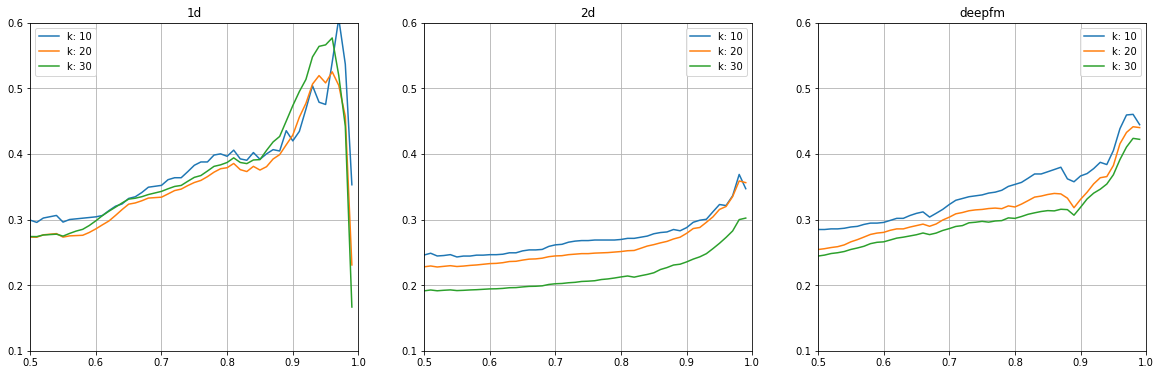

In [37]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
for i, model_tuple in zip(range(len(eval_models)), eval_models):
    for k in eval_k:
        model_name, model = model_tuple
        bol = (f1_res.k == k) & (f1_res.algorithm == model_name)
        ax[i].plot(f1_res[bol]["threshold"], f1_res[bol]["f1"], label=f"k: {k}")
    ax[i].set_title(model_name)
    ax[i].legend()
    ax[i].axis('square')
    ax[i].set_ylim(0.1, 0.6)
    ax[i].set_xlim(0.5, 1.0)
    ax[i].grid()
plt.show()

In [9]:
f1_res[f1_res.threshold == 0.99]

NameError: name 'f1_res' is not defined

## 3. Feature importance

In [24]:
# TODO: feature importance for model in shapley

In [25]:
len(transactions["prod"].unique())

12304

In [26]:
# e = shap.DeepExplainer(model, test_x)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


In [27]:
# shap_values = e.shap_values(test_x)
#shap.image_plot(shap_values, test_y)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


StagingError: in user code:

    C:\Users\david\anaconda3\envs\shapley\lib\site-packages\shap\explainers\_deep\deep_tf.py:248 grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)
    C:\Users\david\anaconda3\envs\shapley\lib\site-packages\tensorflow\python\eager\backprop.py:1074 gradient  **
        flat_grad = imperative_grad.imperative_grad(
    C:\Users\david\anaconda3\envs\shapley\lib\site-packages\tensorflow\python\eager\imperative_grad.py:71 imperative_grad
        return pywrap_tfe.TFE_Py_TapeGradient(
    C:\Users\david\anaconda3\envs\shapley\lib\site-packages\tensorflow\python\eager\backprop.py:148 _gradient_function
        grad_fn = ops._gradient_registry.lookup(op_name)  # pylint: disable=protected-access
    C:\Users\david\anaconda3\envs\shapley\lib\site-packages\tensorflow\python\framework\registry.py:99 lookup
        raise LookupError(

    LookupError: gradient registry has no entry for: shap_AddV2
